# Framing analysis

In [4]:
!pip install bertopic
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import pandas as pd
import os, random, numpy as np
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(42); np.random.seed(42)

import torch
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
device = "cpu"

from umap import UMAP
from hdbscan import HDBSCAN

import matplotlib.pyplot as plt
import plotly.io as pio
import seaborn as sns
from pathlib import Path
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from plotly import graph_objects as go
import spacy

# Styling 
sns.set(style="whitegrid")

### Loading data and transforming from .xlsx to .csv

In [9]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_ds_emoji.xlsx"
df_ds = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_ds_emoji.csv"
df_ds.to_csv(csv_path, index=False)

In [10]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_ko_emoji.xlsx"
df_ko = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_ko_emoji.csv"
df_ko.to_csv(csv_path, index=False)

In [11]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_no_emoji.xlsx"
df_no = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_no_emoji.csv"
df_no.to_csv(csv_path, index=False)

In [6]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_uo_emoji.xlsx"
df_uo = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_uo_emoji.csv"
df_uo.to_csv(csv_path, index=False)

In [7]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_cl_emoji.xlsx"
df_cl = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_cl_emoji.csv"
df_cl.to_csv(csv_path, index=False)

In [8]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_dm_emoji.xlsx"
df_dm = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_dm_emoji.csv"
df_dm.to_csv(csv_path, index=False)

In [9]:
# Loading the Excel file
excel_path = "data/analysis/processed/framing_matrix_re_emoji.xlsx"
df_re = pd.read_excel(excel_path)

# Saving it as a CSV file
csv_path = "data/analysis/processed_csv/framing_matrix_re_emoji.csv"
df_re.to_csv(csv_path, index=False)

In [12]:
data_dir = Path("data/analysis/processed_csv")

# Russia-aligned channels
ru_files = [
    "framing_matrix_cl_emoji.csv",
    "framing_matrix_dm_emoji.csv",
    "framing_matrix_re_emoji.csv"
]

# Ukraine-aligned channels
ukr_files = [
    "framing_matrix_ds_emoji.csv",
    "framing_matrix_ko_emoji.csv",
    "framing_matrix_no_emoji.csv",
    "framing_matrix_uo_emoji.csv"
]

# Loading Russian channels
dfs_ru = []
for fname in ru_files:
    df = pd.read_csv(data_dir / fname)
    df["source"] = fname.replace("framing_matrix_", "").replace("_emoji.csv", "")
    dfs_ru.append(df)
df_ru = pd.concat(dfs_ru, ignore_index=True)
df_ru["bloc"] = "pro-russian"

# Loading Ukrainian channels
dfs_ukr = []
for fname in ukr_files:
    df = pd.read_csv(data_dir / fname)
    df["source"] = fname.replace("framing_matrix_", "").replace("_emoji.csv", "")
    dfs_ukr.append(df)
df_ukr = pd.concat(dfs_ukr, ignore_index=True)
df_ukr["bloc"] = "pro-ukrainian"

Creating a column that acts like a switch for contrasting time windows.

In [13]:
df_ru["date"] = pd.to_datetime(df_ru["date"]).dt.tz_localize(None)
df_ukr["date"] = pd.to_datetime(df_ukr["date"]).dt.tz_localize(None)

event_date = pd.to_datetime("2025-02-28")

df_ru["period"] = df_ru["date"].apply(lambda x: "pre" if x < event_date else "post")
df_ukr["period"] = df_ukr["date"].apply(lambda x: "pre" if x < event_date else "post")

### Filtering data according to the relevant data

In [14]:
# Combining data
df_all = pd.concat([df_ru, df_ukr], ignore_index=True)

# Aggregating relevance by channel
relevance_stats = (
    df_all.groupby(["bloc", "source"])["is_relevant"]
    .agg(total_posts="count", relevant_posts="sum")
    .assign(percent_relevant=lambda x: x["relevant_posts"] / x["total_posts"] * 100)
    .reset_index()
)

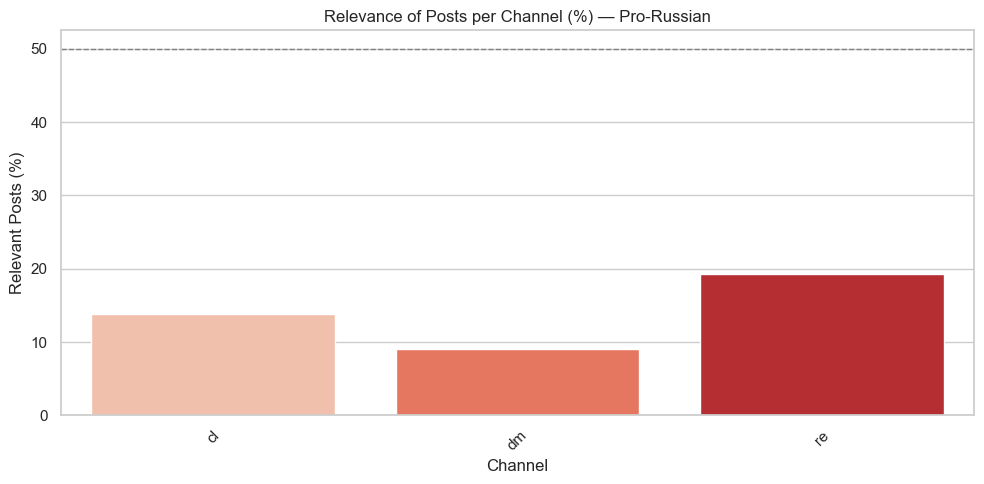

In [15]:
# --- Pro-Russian ---
relevance_ru = (
    df_ru.groupby("source")["is_relevant"]
    .agg(total_posts="count", relevant_posts="sum")
    .assign(percent_relevant=lambda x: x["relevant_posts"] / x["total_posts"] * 100)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=relevance_ru,
    x="source", y="percent_relevant",
    palette="Reds"
)
plt.axhline(50, color="gray", linestyle="--", linewidth=1)
plt.title("Relevance of Posts per Channel (%) — Pro-Russian")
plt.ylabel("Relevant Posts (%)")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/ru/relevance_of_posts_chart_ru.png", dpi=600, bbox_inches="tight")
plt.show()

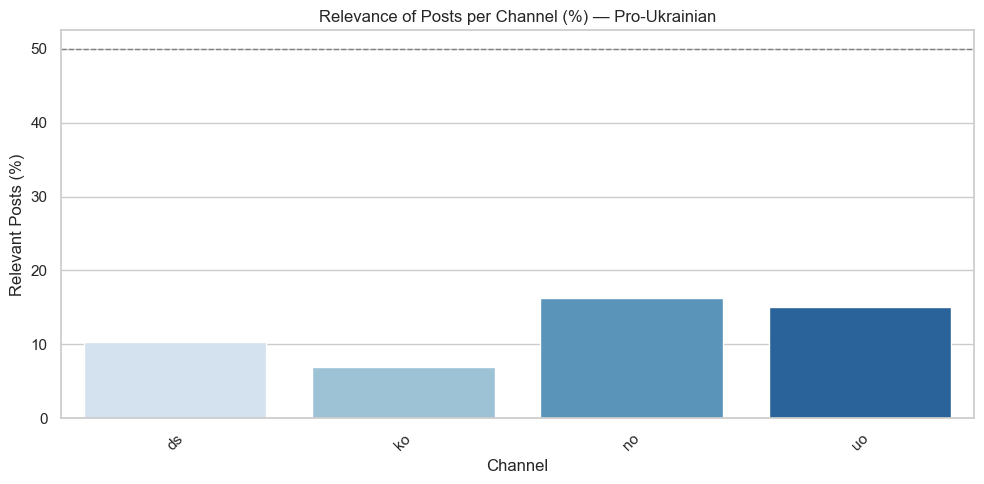

In [16]:
# --- Pro-Ukrainian ---
relevance_ukr = (
    df_ukr.groupby("source")["is_relevant"]
    .agg(total_posts="count", relevant_posts="sum")
    .assign(percent_relevant=lambda x: x["relevant_posts"] / x["total_posts"] * 100)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=relevance_ukr,
    x="source", y="percent_relevant",
    palette="Blues"
)
plt.axhline(50, color="gray", linestyle="--", linewidth=1)
plt.title("Relevance of Posts per Channel (%) — Pro-Ukrainian")
plt.ylabel("Relevant Posts (%)")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/ukr/relevance_of_posts_chart_ukr.png", dpi=600, bbox_inches="tight")
plt.show()

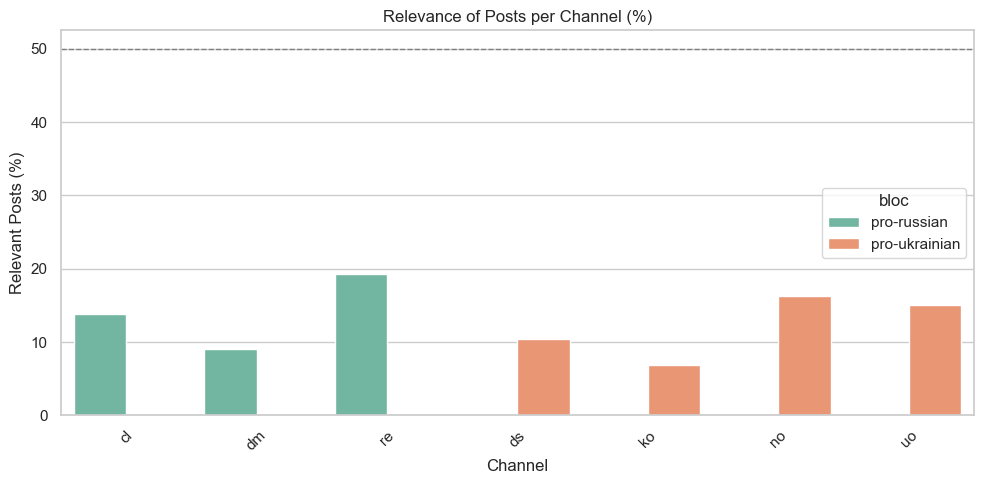

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=relevance_stats,
    x="source", y="percent_relevant", hue="bloc",
    palette="Set2"
)
plt.axhline(50, color="gray", linestyle="--", linewidth=1)
plt.title("Relevance of Posts per Channel (%)")
plt.ylabel("Relevant Posts (%)")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/relevance_of_posts_chart.png", dpi=600, bbox_inches="tight")
plt.show()

### Quote_only posts

In [18]:
# Filtering to relevant posts only
df_relevant = df_all[df_all["is_relevant"] == 1]

# Calculating quote-only rate among relevant posts per channel
quote_only_stats = (
    df_relevant.groupby(["bloc", "source"])["quote_only"]
    .agg(total_relevant="count", quote_only="sum")
    .assign(percent_quote_only=lambda x: x["quote_only"] / x["total_relevant"] * 100)
    .reset_index()
)

In [19]:
def plot_quote_only_by_channel(df, bloc_label, outpath):
    """
    Creates a bar plot showing the percentage of "quote-only" posts 
    among all relevant posts per channel, for a given bloc 
    (e.g., pro-Russian or pro-Ukrainian).
    """
    
    # Keeping only relevant posts
    df_rel = df[df["is_relevant"] == 1].copy()

    # Aggregating: quote-only share among relevant per channel
    quote_stats = (
        df_rel.groupby("source")["quote_only"]
        .agg(total_relevant="count", quote_only="sum")
        .assign(percent_quote_only=lambda x: x["quote_only"] / x["total_relevant"] * 100)
        .reset_index()
        .sort_values("source")
    )
    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=quote_stats,
        x="source", y="percent_quote_only",
        color="tab:blue" if bloc_label == "pro-russian" else "tab:orange"
    )
    plt.axhline(50, linestyle="--", color="gray", linewidth=1)
    plt.title(f"Quote-Only Posts Among Relevant Posts (%) — {bloc_label.title()}")
    plt.ylabel("Quote-Only (%)")
    plt.xlabel("Channel")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(outpath, dpi=600, bbox_inches="tight")
    plt.show()

    return quote_stats

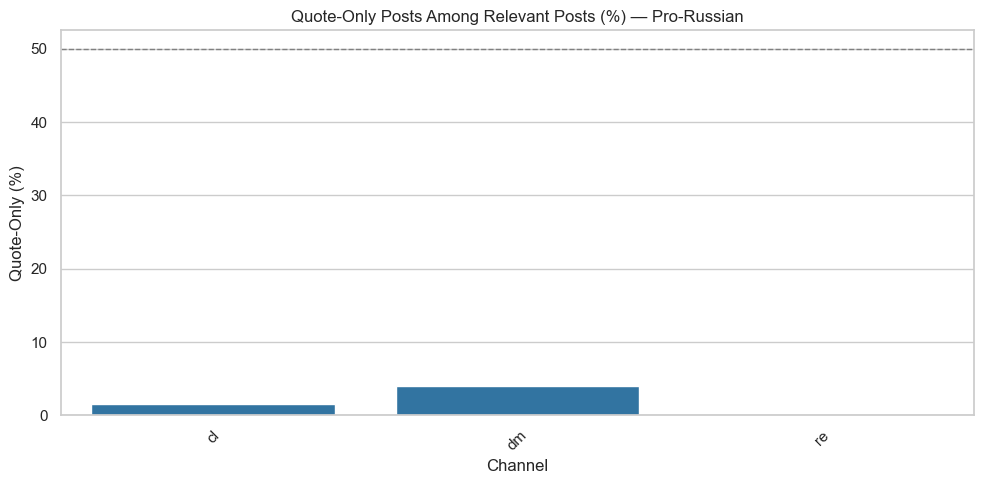

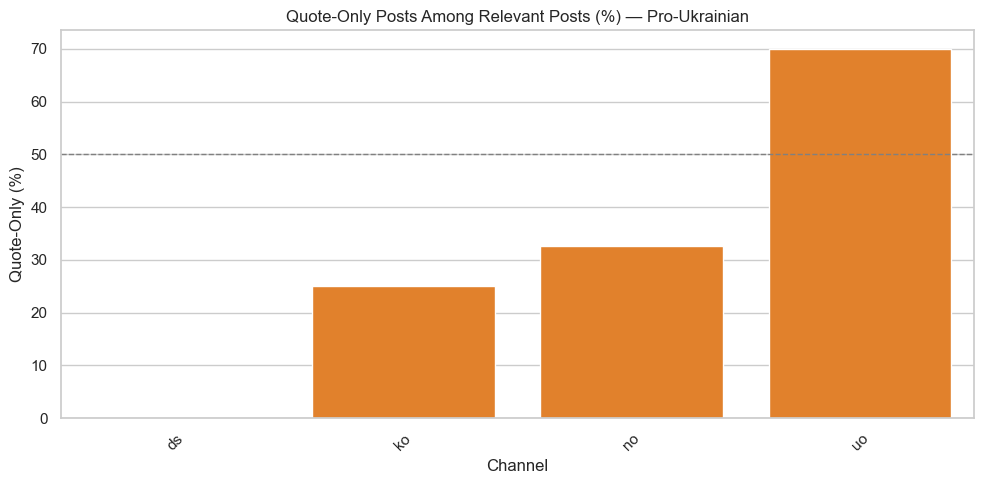

In [20]:
stats_ru = plot_quote_only_by_channel(
    df_ru, "pro-russian", "figures/ru/quote_only_posts_chart_ru.png"
)

stats_ukr = plot_quote_only_by_channel(
    df_ukr, "pro-ukrainian", "figures/ukr/quote_only_posts_chart_ukr.png"
)

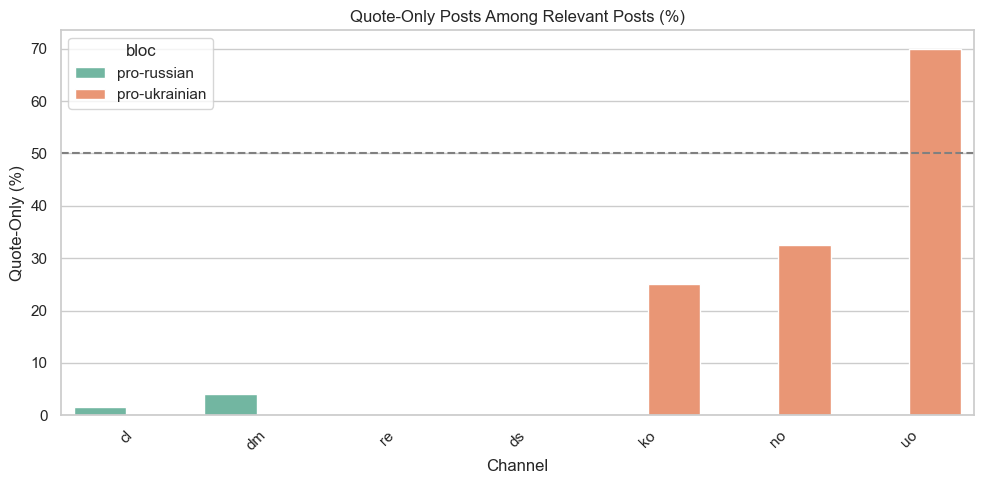

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=quote_only_stats,
    x="source", y="percent_quote_only", hue="bloc",
    palette="Set2"
)
plt.axhline(50, linestyle="--", color="gray")
plt.title("Quote-Only Posts Among Relevant Posts (%)")
plt.ylabel("Quote-Only (%)")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/quote_only_posts_chart.png", dpi=600, bbox_inches="tight")
plt.show()

# Aggregate binary variable frequencies

In [22]:
# Defining binary framing variables
binary_vars = [
    "betrayal", "heroism", "appeasement", "fear", "anger", "pride", "dehumanization", "mockery", "USA_blame", "Russia_blame"
]

In [23]:
df_relevant = df_all[df_all["is_relevant"] == 1].copy()

In [24]:
df_relevant.columns = df_all.columns.str.strip().str.replace(r'\s+', '_', regex=True)

In [25]:
# Aggregating group by channel and calculate % presence of each variable
# Computing mean for binary vars → gives % of posts where each frame appears
framing_freqs = (
    df_relevant.groupby(["bloc", "source"])[binary_vars]
    .mean()
    .multiply(100)  # to percentages
    .reset_index()
)

In [26]:
# Melting for grouped bar plot
framing_melted = framing_freqs.melt(
    id_vars=["bloc", "source"],
    var_name="frame",
    value_name="frequency"
)

In [27]:
def compute_and_plot_binary_by_channel(df_bloc, bloc_label, outdir):
    """
    df_bloc   : dataframe for a single bloc (already filtered to RU or UKR)
    bloc_label: string for titles/filenames, e.g. "pro-russian" / "pro-ukrainian"
    outdir    : directory to save CSV/figures, e.g. "figures/ru" or "figures/ukr"
    """
    Path(outdir).mkdir(parents=True, exist_ok=True)

    # Only relevant posts
    df_rel = df_bloc[df_bloc["is_relevant"] == 1].copy()

    # Guard against missing columns
    vars_present = [v for v in binary_vars if v in df_rel.columns]
    if not vars_present:
        raise ValueError("None of the specified binary_vars are present in this dataframe.")

    # Computing % presence of each binary var per channel
    freq_wide = (
        df_rel.groupby("source")[vars_present]
        .mean()
        .mul(100)                        # convert to %
        .reset_index()
        .sort_values("source")
    )

    # Saving wide table for appendix
    csv_wide = Path(outdir) / "binary_var_frequencies_by_channel_wide.csv"
    freq_wide.to_csv(csv_wide, index=False)

    # Melting for grouped bar plot
    freq_long = freq_wide.melt(
        id_vars="source", var_name="frame", value_name="frequency"
    )

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=freq_long, x="source", y="frequency", hue="frame", palette="tab10"
    )
    plt.title(f"Binary Framing Variable Frequencies by Channel — {bloc_label.title()}")
    plt.ylabel("Frequency (%)")
    plt.xlabel("Channel")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    png_path = Path(outdir) / "binary_var_freq_by_channel.png"
    plt.savefig(png_path, dpi=600, bbox_inches="tight")
    plt.show()

    return freq_wide, freq_long, str(csv_wide), str(png_path)

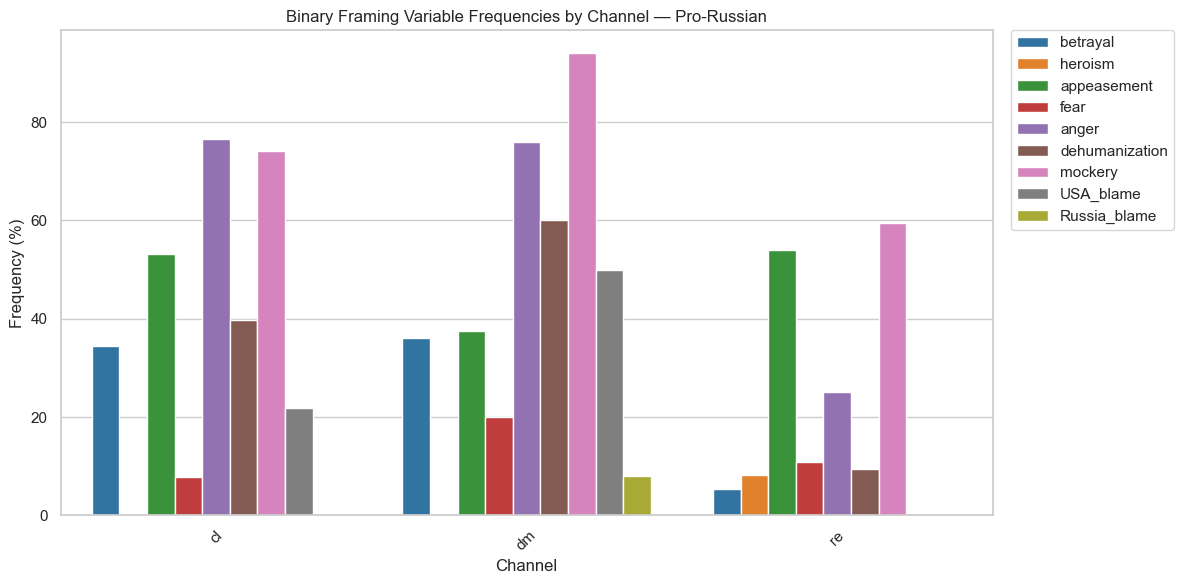

In [28]:
# --- Pro-Russian --- 
ru_wide, ru_long, ru_csv, ru_png = compute_and_plot_binary_by_channel(
    df_ru, bloc_label="pro-russian", outdir="figures/ru"
)

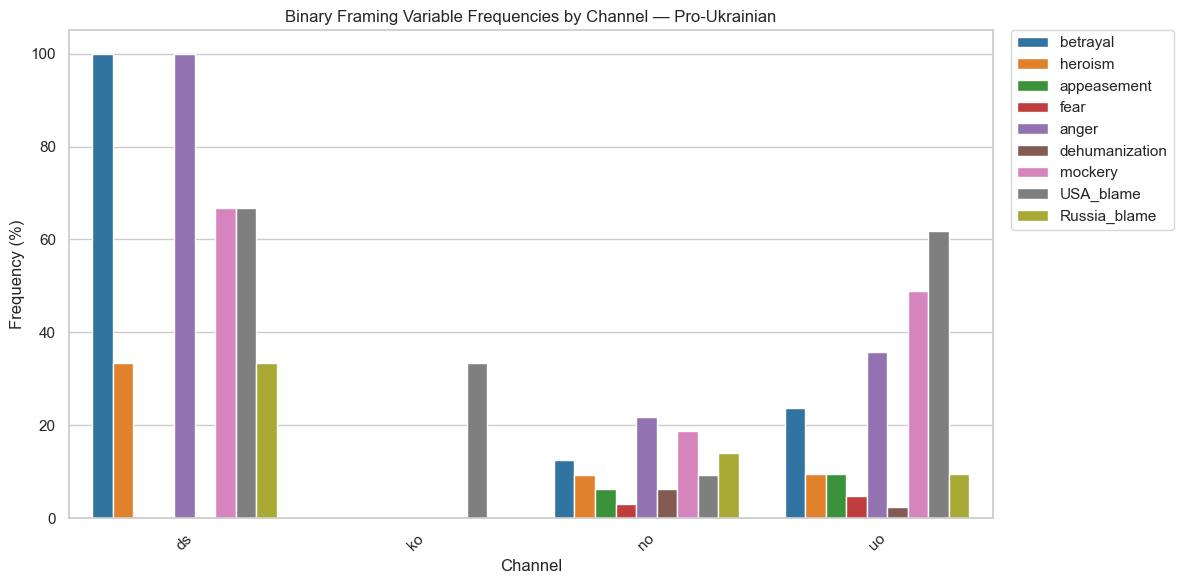

In [29]:
# --- Pro-Ukrainian --- 
ukr_wide, ukr_long, ukr_csv, ukr_png = compute_and_plot_binary_by_channel(
    df_ukr, bloc_label="pro-ukrainian", outdir="figures/ukr"
)

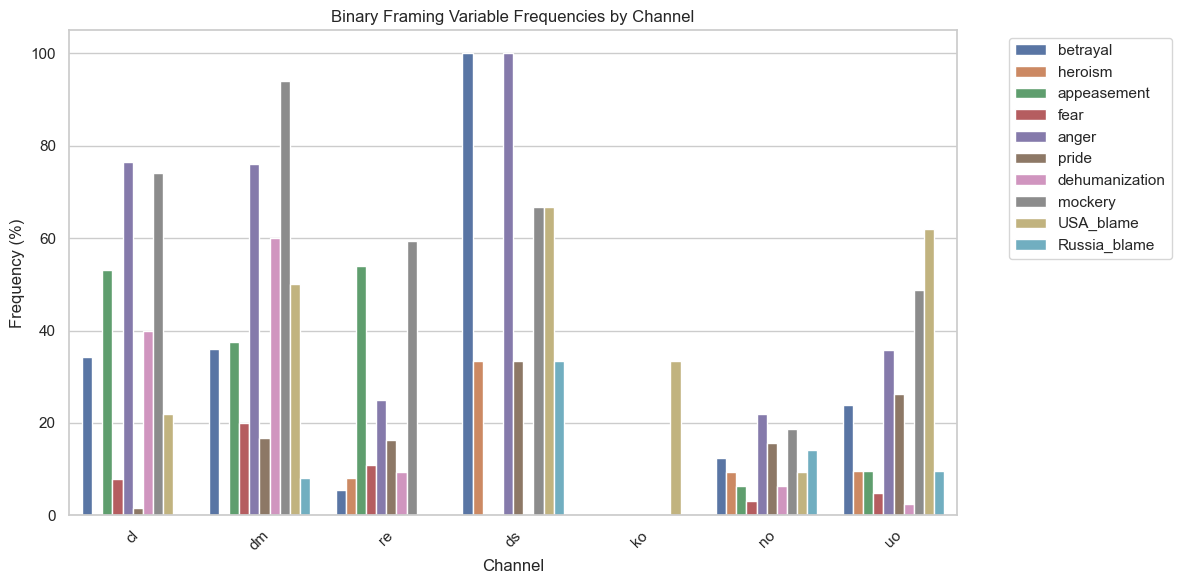

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=framing_melted,
    x="source", y="frequency", hue="frame"
)
plt.title("Binary Framing Variable Frequencies by Channel")
plt.ylabel("Frequency (%)")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("figures/binary_var_freq_chart.png", dpi=600, bbox_inches="tight")
plt.show()

In [31]:
def compute_and_plot_avg_framing(df, bloc_label, outdir):
    """
    Compute average framing frequencies for a given bloc DataFrame and save results.
    """
    # Filtering relevant posts
    df_rel = df[df["is_relevant"] == 1].copy()
    df_rel.columns = df_rel.columns.str.strip().str.replace(r"\s+", "_", regex=True)

    # Calculating average frequency (%) for each binary variable
    avg_freq = df_rel[binary_vars].mean().mul(100).reset_index()
    avg_freq.columns = ["frame", "frequency"]

    # Saving CSV
    Path(outdir).mkdir(parents=True, exist_ok=True)
    csv_path = os.path.join(outdir, "avg_framing_frequency.csv")
    avg_freq.to_csv(csv_path, index=False)

    # Saving plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=avg_freq, y="frame", x="frequency", palette="Set2")
    plt.title(f"Average Framing Frequency — {bloc_label} Channels")
    plt.xlabel("Frequency (%)")
    plt.ylabel("Frame")
    plt.xlim(0, 100)
    plt.tight_layout()
    png_path = os.path.join(outdir, "avg_fram_freq.png")
    plt.savefig(png_path, dpi=600, bbox_inches="tight")
    plt.show()

    return avg_freq, csv_path, png_path

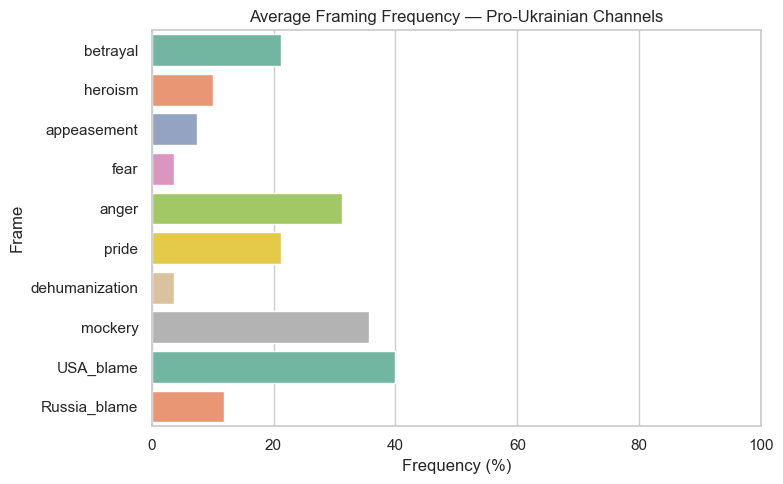

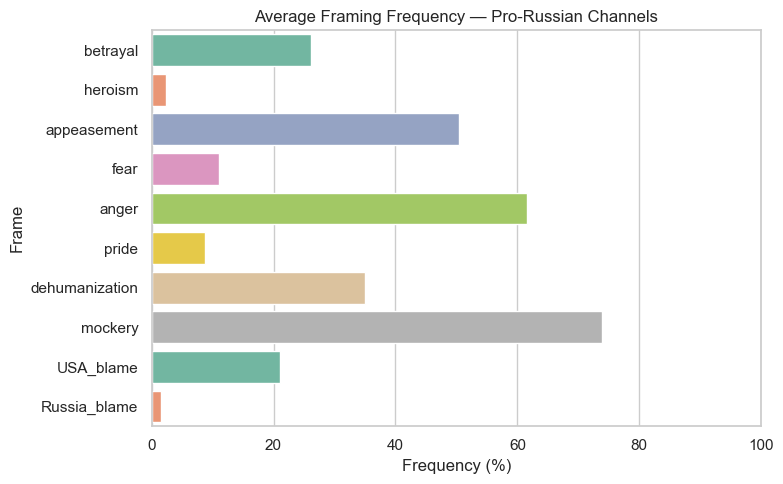

In [32]:
# --- Running for both blocs ---
ukr_avg, ukr_csv, ukr_png = compute_and_plot_avg_framing(
    df_ukr, bloc_label="Pro-Ukrainian", outdir="figures/ukr"
)
ru_avg, ru_csv, ru_png = compute_and_plot_avg_framing(
    df_ru, bloc_label="Pro-Russian", outdir="figures/ru"
)

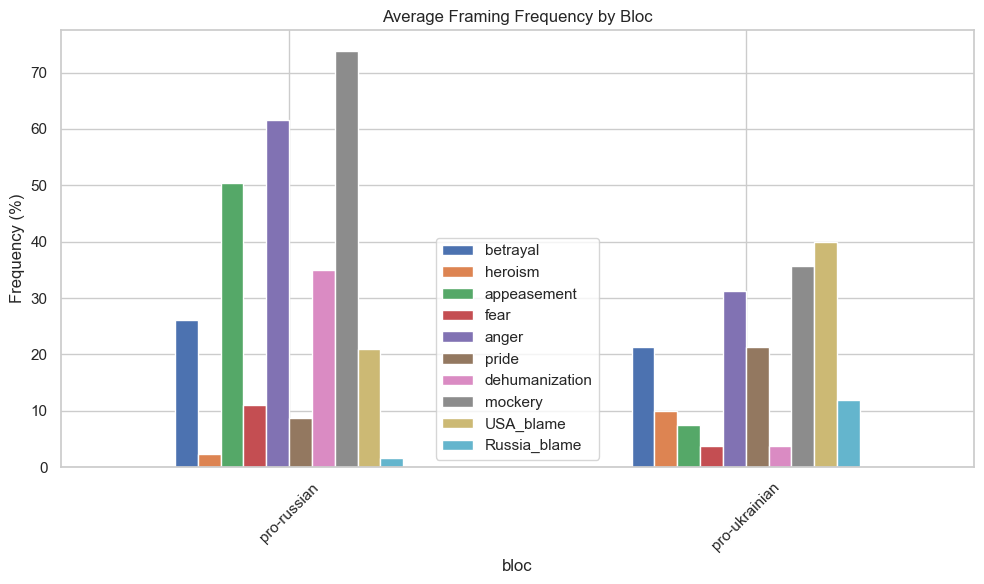

In [33]:
# Comparing average framing frequencies between pro-ukrainian and pro-russian channels
bloc_framing = (
    df_relevant.groupby("bloc")[binary_vars]
    .mean()
    .multiply(100)
    .T  
)

bloc_framing.T.plot(kind="bar", figsize=(10, 6), title="Average Framing Frequency by Bloc")
plt.ylabel("Frequency (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/avg_fram_freq_chart.png", dpi=600, bbox_inches="tight")
plt.show()

In [34]:
for col in binary_vars:
    if col not in df_ukr.columns:
        df_ukr[col] = 0
    if col not in df_ru.columns:
        df_ru[col] = 0

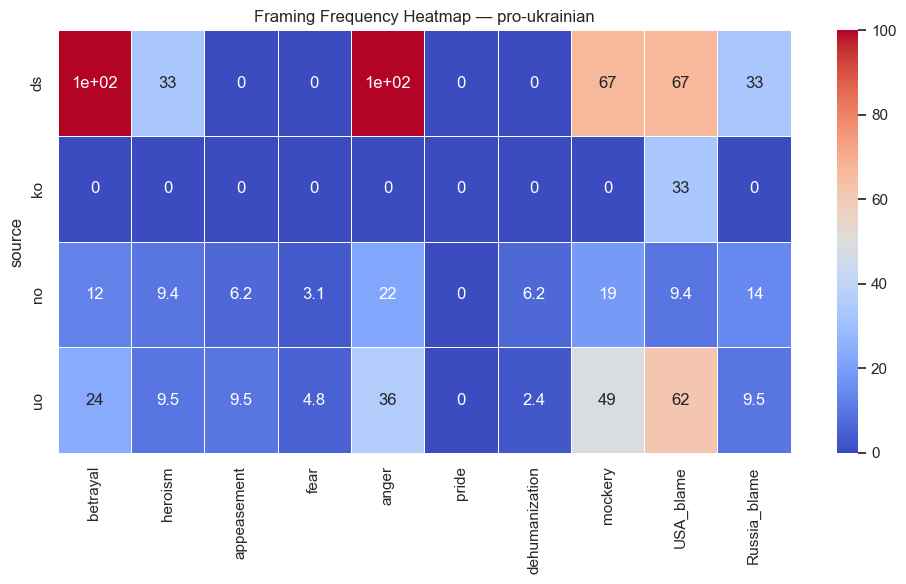

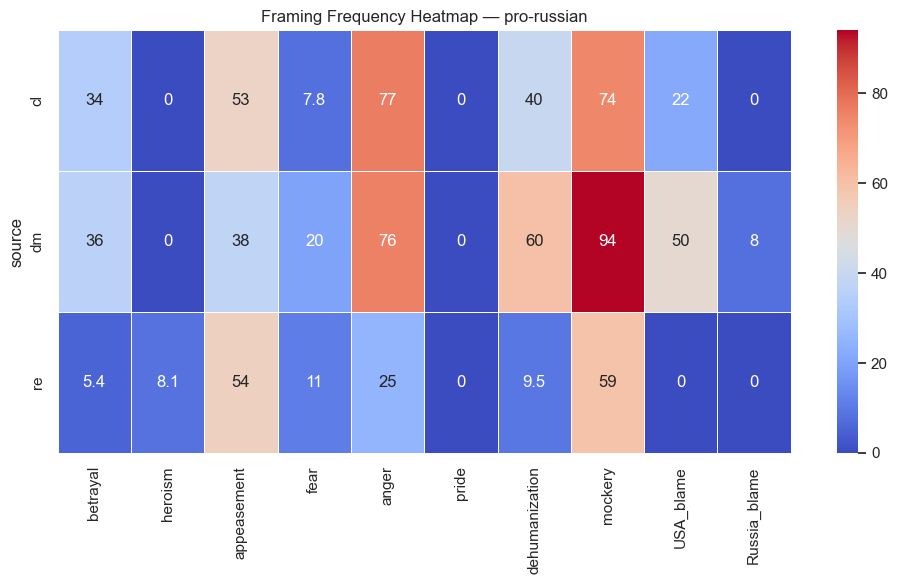

In [35]:
def plot_framing_heatmap(df, bloc_label, outdir):
    # Filter relevant posts
    df_rel = df[df["is_relevant"] == 1].copy()
    
    # Calculate mean % per channel
    heatmap_df = (
        df_rel.groupby("source")[binary_vars]
        .mean()
        .multiply(100)
    )
    
    # Save CSV
    csv_path = os.path.join(outdir, "fram_freq_heatmap.csv")
    heatmap_df.to_csv(csv_path, index=True)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title(f"Framing Frequency Heatmap — {bloc_label}")
    plt.tight_layout()
    png_path = os.path.join(outdir, "fram_freq_heatmap.png")
    plt.savefig(png_path, dpi=600, bbox_inches="tight")
    plt.show()
    
    return heatmap_df, csv_path, png_path


# Running separately for each bloc
ukr_heatmap, ukr_csv, ukr_png = plot_framing_heatmap(df_ukr, "pro-ukrainian", "figures/ukr")
ru_heatmap,  ru_csv,  ru_png  = plot_framing_heatmap(df_ru,  "pro-russian",  "figures/ru")

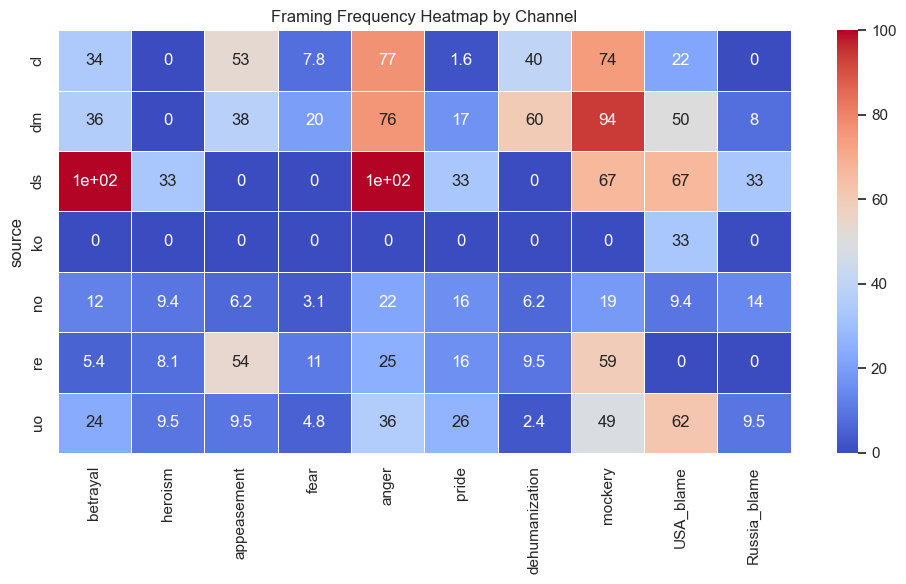

In [36]:

heatmap_df = (
    df_relevant.groupby("source")[binary_vars]
    .mean()
    .multiply(100)
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Framing Frequency Heatmap by Channel")
plt.tight_layout()
plt.savefig("figures/fram_freq_heatmap.png", dpi=600, bbox_inches="tight")
plt.show()

# Credibility per Channel + Timeline Analysis

In [70]:
# Ensuring column names are cleaned
df_relevant.columns = df_relevant.columns.str.strip().str.replace(r'[\s\t\r\n]+', '_', regex=True)

In [71]:
# Ensuring "credibility" column is numeric
df_relevant["credibility"] = pd.to_numeric(df_relevant["credibility"], errors="coerce")


In [72]:
# ---- Bar plot: Credibility per channel ----
cred_per_channel = (
    df_relevant.groupby(["bloc", "source"])["credibility"]
    .mean()
    .reset_index()
)

In [73]:
# ---- Helpers ----
def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def plot_credibility_by_channel(df_subset, bloc_label, outdir):
    """Make per-channel credibility bar chart for a single bloc."""
    _ensure_dir(outdir)

    # Cleaning column names
    df = df_subset.copy()
    df.columns = df.columns.str.strip().str.replace(r'[\s\t\r\n]+', '_', regex=True)

    # Making sure "credibility" exists and is numeric
    if "credibility" not in df.columns:
        df["credibility"] = 0  # if missing, create with zeros
    df["credibility"] = pd.to_numeric(df["credibility"], errors="coerce").fillna(0)

    # Aggregating
    cred_per_channel = (
        df.groupby("source", as_index=False)["credibility"]
          .mean()
          .rename(columns={"credibility": "mean_credibility"})
    )

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(data=cred_per_channel, x="source", y="mean_credibility")
    plt.axhline(1.0, linestyle="--", color="gray")  # midpoint (0..2 scale)
    plt.title(f"Average Credibility Score per Channel — {bloc_label}\n(0 = Not Credible, 2 = Fully Credible)")
    plt.ylabel("Mean Credibility")
    plt.xlabel("Channel")
    plt.xticks(rotation=45)
    plt.tight_layout()

    png_path = os.path.join(outdir, "avg_credibility_per_channel.png")
    plt.savefig(png_path, dpi=600, bbox_inches="tight")
    plt.show()

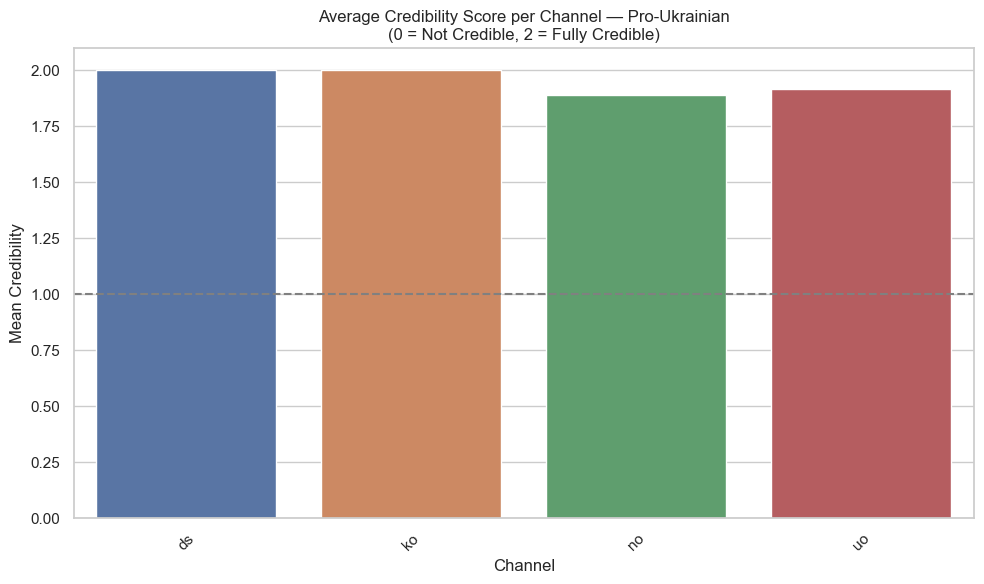

TypeError: cannot unpack non-iterable NoneType object

In [74]:
# Filtering to relevant posts first
df_relevant = df_all.copy()
df_relevant.columns = df_relevant.columns.str.strip().str.replace(r'[\s\t\r\n]+', '_', regex=True)
if "is_relevant" in df_relevant.columns:
    df_relevant = df_relevant[df_relevant["is_relevant"] == 1].copy()

# Making bloc-specific subsets
df_ru_rel  = df_relevant[df_relevant["bloc"].str.lower().str.contains("ru")].copy()
df_ukr_rel = df_relevant[df_relevant["bloc"].str.lower().str.contains("ukr")].copy()

# ---- Running for both blocs ----
ukr_table, ukr_csv, ukr_png = plot_credibility_by_channel(
    df_ukr_rel, bloc_label="Pro-Ukrainian", outdir="figures/ukr"
)
ru_table, ru_csv, ru_png = plot_credibility_by_channel(
    df_ru_rel, bloc_label="Pro-Russian", outdir="figures/ru"
)

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=cred_per_channel, x="source", y="credibility", hue="bloc")
plt.axhline(1.0, linestyle="--", color="gray")  # Midpoint for interpretation
plt.title("Average Credibility Score per Channel\n(0 = Not Credible, 2 = Fully Credible)")
plt.ylabel("Mean Credibility")
plt.xlabel("Channel")
plt.tight_layout()
plt.savefig("figures/avg_credibility_chart.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# Credibility over time by bloc
df_relevant["date"] = pd.to_datetime(df_relevant["date"]).dt.date  # Ensure proper date format

cred_over_time = (
    df_relevant.groupby(["date", "bloc"])["credibility"]
    .mean()
    .reset_index()
)

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=cred_over_time, x="date", y="credibility", hue="bloc")
plt.axhline(1.0, linestyle="--", color="gray")
plt.title("Credibility Over Time by Bloc")
plt.ylabel("Mean Credibility")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("figures/credibility_overtime_chart.png", dpi=600, bbox_inches="tight")
plt.show()


1. Pro-Ukrainian bloc stays highly stable and credible
The blue line hovers around 2.0, occasionally dipping slightly (e.g., Mar 1–2).

This suggests these channels framed their coverage as highly official, verified, or authoritative, consistently.

2. Pro-Russian bloc shows post-event destabilization
Initially around 1.0–1.2, meaning mixed credibility: some factual reporting, some heavy editorializing.

Steep decline after March 1st, hitting zero by March 5.

This could mean: more sarcastic, ironic, or fabricated content.


#  Qualitative variable analysis

### Topic modeling

In [75]:
df_narrative = df_relevant[
    (df_relevant["narrative_summary"].notna()) &
    (df_relevant["quote_only"] == 0)
].copy()
df_ukr = df_narrative[df_narrative["bloc"] == "pro-ukrainian"].copy()
df_ru  = df_narrative[df_narrative["bloc"] == "pro-russian"].copy()

# --- Helper: add numbers & save ---
def save_intertopic_with_numbers(topic_model, out_html, out_png,
                                 width=1200, height=1200, scale=2):
    """
    Build the intertopic distance map, overlay Topic IDs inside bubbles,
    and save HTML + PNG. Robust to missing hovertext/customdata.
    """
    fig = topic_model.visualize_topics()         # Plotly Figure
    if not fig.data:
        print("⚠️ No traces returned by visualize_topics(); skipping save.")
        return None

    # Try to find the bubble trace (usually the first one)
    scatter = None
    for tr in fig.data:
        if getattr(tr, "mode", "") == "markers":
            scatter = tr
            break
    if scatter is None or scatter.x is None or scatter.y is None:
        print("⚠️ No bubble trace with coordinates found; skipping save.")
        return None

    xs = list(scatter.x)
    ys = list(scatter.y)

    # Try to extract topic IDs from customdata first, then hovertext
    topic_ids = []
    cd = getattr(scatter, "customdata", None)
    if cd is not None:
        # BERTopic typically stores topic id as first element of customdata row
        for row in cd:
            try:
                topic_ids.append(int(row[0]))
            except Exception:
                topic_ids.append(None)
    else:
        # Fallback: parse hovertext like "Topic 3: ..."
        ht = getattr(scatter, "hovertext", None)
        if ht is not None:
            for s in ht:
                try:
                    topic_ids.append(int(str(s).split("Topic ")[1].split(":")[0]))
                except Exception:
                    topic_ids.append(None)
        else:
            # Last resort: align with get_topic_info() order (excluding -1)
            info = topic_model.get_topic_info()
            ordered = info.loc[info["Topic"] != -1, "Topic"].tolist()
            topic_ids = ordered[:len(xs)]
            topic_ids += [None] * (len(xs) - len(topic_ids))

    # Add number labels
    for x, y, tid in zip(xs, ys, topic_ids):
        if tid is None:
            continue
        fig.add_annotation(
            x=x, y=y, text=str(tid),
            showarrow=False,
            font=dict(size=16, color="#1f2937"),
            xanchor="center", yanchor="middle"
        )

    # Save HTML always
    os.makedirs(os.path.dirname(out_html) or ".", exist_ok=True)
    fig.write_html(out_html)

    # Save PNG if kaleido is available
    try:
        pio.write_image(fig, out_png, width=width, height=height, scale=scale)
    except Exception as e:
        print(f"ℹ️ PNG export failed (install kaleido?): {e}")

    return fig


In [76]:
# --- Ukrainian topics ---

pio.renderers.default = "notebook_connected"
os.makedirs("figures/ukr", exist_ok=True)
os.makedirs("models", exist_ok=True)

texts_ukr = df_ukr["narrative_summary"].astype(str).str.strip().tolist()
texts_ukr = [t for t in texts_ukr if len(t.split()) > 3]
if len(texts_ukr) == 0:
    print("No Ukrainian texts with >3 words — skipping BERTopic.")
else:
    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
    umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0,
                      metric="cosine", random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=5, metric="euclidean",
                            cluster_selection_method="eom",
                            prediction_data=True, gen_min_span_tree=True)

    topic_model_ukr = BERTopic(
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=5,
        language="english",
        calculate_probabilities=True,
        verbose=False,
    )

    topics_ukr, probs_ukr = topic_model_ukr.fit_transform(texts_ukr)
    topic_model_ukr.save("models/topic_model_ukr")

    labels = topic_model_ukr.generate_topic_labels(nr_words=3, separator="_", topic_prefix="")
    topic_model_ukr.set_topic_labels(labels)

    topic_model_ukr.get_topic_info().to_csv("figures/ukr/topics_summary_ukr.csv", index=False)

    save_intertopic_with_numbers(
        topic_model_ukr,
        out_html="figures/ukr/intertopic_map_ukr.html",
        out_png="figures/ukr/intertopic_map_ukr.png"
    )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-09-10 12:53:40,340 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [77]:
# --- Russian topics ---

pio.renderers.default = "notebook_connected"
os.makedirs("figures/ru", exist_ok=True)
os.makedirs("models", exist_ok=True)

texts_ru = df_ru["narrative_summary"].astype(str).str.strip().tolist()
texts_ru = [t for t in texts_ru if len(t.split()) > 3]
if len(texts_ru) == 0:
    print("No Russian texts with >3 words — skipping BERTopic.")
else:
    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
    umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0,
                      metric="cosine", random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=5, metric="euclidean",
                            cluster_selection_method="eom",
                            prediction_data=True, gen_min_span_tree=True)

    topic_model_ru = BERTopic(
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=5,
        language="english",
        calculate_probabilities=True,
        verbose=False,
    )

    topics_ru, probs_ru = topic_model_ru.fit_transform(texts_ru)
    topic_model_ru.save("models/topic_model_ru")

    labels = topic_model_ru.generate_topic_labels(nr_words=3, separator="_", topic_prefix="")
    topic_model_ru.set_topic_labels(labels)

    topic_model_ru.get_topic_info().to_csv("figures/ru/topics_summary_ru.csv", index=False)

    save_intertopic_with_numbers(
        topic_model_ru,
        out_html="figures/ru/intertopic_map_ru.html",
        out_png="figures/ru/intertopic_map_ru.png"
    )

2025-09-10 12:54:10,354 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [78]:
# --- Ukrainian plot --- 
fig_ukr_barchart = topic_model_ukr.visualize_barchart(top_n_topics=5)

# Save as HTML for interactive viewing
fig_ukr_barchart.write_html("figures/ukr/topic_barchart.html")

# Optionally save as PNG (requires kaleido installed)
# pip install -U kaleido
fig_ukr_barchart.write_image("figures/ukr/topic_barchart.png", scale=2)
fig_ukr_barchart.show()

In [ ]:
# --- Russian plot ---
fig_ru_barchart = topic_model_ru.visualize_barchart(top_n_topics=5)

# Save as HTML for interactive viewing
fig_ru_barchart.write_html("figures/ru/topic_barchart.html")

# Optionally save as PNG (requires kaleido installed)
# pip install -U kaleido
fig_ru_barchart.write_image("figures/ru/topic_barchart.png", scale=2)
fig_ru_barchart.show()

In [ ]:
# Assigning topics to df_ukr after fitting BERTopic
df_ukr = df_ukr.copy()  # keep safe copy
df_ukr["topic"] = topics_ukr  # from topic_model_ukr.fit_transform

# Plotting
pd.crosstab(df_ukr["source"], df_ukr["topic"]).plot(
    kind="bar", stacked=True, figsize=(12, 6)
)
plt.title("Topic Spread Across Ukrainian Channels")
plt.xlabel("Channel")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.savefig("figures/ukr/topic_spread_chart_ukr.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# Assigning topics to df_ukr after fitting BERTopic
df_ru = df_ru.copy()
df_ru["topic"] = topics_ru 

# Plotting
pd.crosstab(df_ru["source"], df_ru["topic"]).plot(
    kind="bar", stacked=True, figsize=(12, 6)
)
plt.title("Topic Spread Across Russian Channels")
plt.xlabel("Channel")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.savefig("figures/ru/topic_spread_chart_ru.png", dpi=600, bbox_inches="tight")
plt.show()


# Entman's four core framing functions analysis

In [ ]:
for var in ["problem_definition", "causal_interpretation", "moral_evaluation", "treatment_recommendation"]:
    print(df_relevant[var].notnull().groupby(df_relevant["bloc"]).mean().round(2))

In [ ]:
data = {
    "frame": ["problem_definition", "causal_interpretation", "moral_evaluation", "treatment_recommendation"],
    "pro-russian":   [0.93, 0.93, 0.93, 0.81],
    "pro-ukrainian": [0.36, 0.36, 0.36, 0.35],
}
df_plot = (
    pd.DataFrame(data)
      .melt(id_vars="frame", var_name="bloc", value_name="proportion")
)

# express as percent for consistency with other figures
df_plot["percent"] = df_plot["proportion"] * 100

def _ensure(p): os.makedirs(p, exist_ok=True)
_ensure("figures"); _ensure("figures/ru"); _ensure("figures/ukr")

# --- combined chart ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="frame", y="percent", hue="bloc")
plt.title("Presence of Entman Frame Functions by Bloc")
plt.ylabel("Proportion of Posts with Frame Element (%)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("figures/entman_presence_by_bloc.png", dpi=600, bbox_inches="tight")
plt.show()
df_plot.to_csv("figures/entman_presence_by_bloc.csv", index=False)

In [ ]:
def plot_per_bloc(dfp, bloc_label, outdir):
    sub = dfp[dfp["bloc"].str.lower() == bloc_label.lower()].copy()
    # Keeping only needed columns
    out_csv = os.path.join(outdir, "entman_presence.csv")
    sub_out = sub[["frame", "percent"]].rename(columns={"percent": "percent_of_posts"})
    sub_out.to_csv(out_csv, index=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=sub, x="frame", y="percent")
    plt.title(f"Presence of Entman Frame Functions — {bloc_label}")
    plt.ylabel("Proportion of Posts with Frame Element (%)")
    plt.xlabel("")
    plt.xticks(rotation=15)
    plt.ylim(0, 100)
    plt.tight_layout()
    out_png = os.path.join(outdir, "entman_presence.png")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()
    return out_csv, out_png

# --- Saving per-bloc charts ---
plot_per_bloc(df_plot, "pro-ukrainian", "figures/ukr")
plot_per_bloc(df_plot, "pro-russian",  "figures/ru")

In [ ]:
df_plot = pd.DataFrame(data).melt(id_vars="frame", var_name="bloc", value_name="proportion")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="frame", y="proportion", hue="bloc")
plt.title("Presence of Entman Frame Functions by Bloc")
plt.ylabel("Proportion of Posts with Frame Element")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("figures/precence_entman_func.png", dpi=600, bbox_inches="tight")
plt.show()

The lower use of Entman’s four framing functions on Ukrainian channels is not necessarily a strategic choice, but a byproduct of many quote-only posts — which contain no text from the channel itself, and thus lack explicit or codable framing.




In [ ]:
# Using quote_only posts
for col in ["problem_definition", "moral_evaluation", "causal_interpretation", "treatment_recommendation"]:
    ukr_pct = df_ukr[col].notna().mean() * 100
    ru_pct = df_ru[col].notna().mean() * 100
    print(f"{col}: UKR {ukr_pct:.1f}% | RU {ru_pct:.1f}%")

In [ ]:
data = {
    "Framing Function": ["problem_definition", "moral_evaluation", "causal_interpretation", "treatment_recommendation"],
    "pro-ukrainian": [88.6, 87.3, 87.3, 86.1],
    "pro-russian": [95.9, 95.9, 95.9, 84.6]
}
df_plot = (
    pd.DataFrame(data)
      .melt(id_vars="Framing Function", var_name="bloc", value_name="percent")
)

# Ensuring dirs
def _ensure(p): os.makedirs(p, exist_ok=True)
_ensure("figures"); _ensure("figures/ru"); _ensure("figures/ukr")

# --- Combined chart ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Framing Function", y="percent", hue="bloc")
plt.title("Coverage of Entman Framing Functions by Bloc")
plt.ylabel("Percentage of Posts with Framing Function")
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.axhline(50, color="gray", linestyle="--", linewidth=0.7)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("figures/entman_frame_coverage_chart.png", dpi=600, bbox_inches="tight")
plt.show()
df_plot.to_csv("figures/entman_frame_coverage_chart.csv", index=False)

In [ ]:
def plot_per_bloc(dfp, bloc_label, outdir):
    sub = dfp[dfp["bloc"].str.lower() == bloc_label.lower()].copy()
    out_csv = os.path.join(outdir, "entman_frame_coverage.csv")
    sub_out = sub[["Framing Function", "percent"]]
    sub_out.to_csv(out_csv, index=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=sub, x="Framing Function", y="percent")
    plt.title(f"Coverage of Entman Framing Functions — {bloc_label}")
    plt.ylabel("Percentage of Posts with Framing Function")
    plt.ylim(0, 100)
    plt.xticks(rotation=30)
    plt.axhline(50, color="gray", linestyle="--", linewidth=0.7)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    out_png = os.path.join(outdir, "entman_frame_coverage.png")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()
    return out_csv, out_png

# Saving per Bloc
plot_per_bloc(df_plot, "pro-ukrainian", "figures/ukr")
plot_per_bloc(df_plot, "pro-russian", "figures/ru")

In [ ]:
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(df))

# Creating grouped bar chart
plt.bar([i - bar_width/2 for i in x], df["pro-ukrainian"], width=bar_width, label="pro-ukrainian")
plt.bar([i + bar_width/2 for i in x], df["pro-russian"], width=bar_width, label="pro-russian")

# Formatting
plt.xticks(ticks=x, labels=df["Framing Function"], rotation=30)
plt.ylabel("Percentage of Posts with Framing Function")
plt.title("Coverage of Entman Framing Functions by Bloc")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.axhline(50, color="gray", linestyle="--", linewidth=0.7)  # Optional reference line
plt.savefig("figures/entman_frame_coverage_chart.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# Only using rows where at least one function is present
cols = ["problem_definition", "moral_evaluation", "causal_interpretation", "treatment_recommendation"]
df_func = df_relevant[df_relevant[cols].notna().any(axis=1)][cols].notna().astype(int)

sns.clustermap(df_func.corr(), cmap="coolwarm", annot=True)
plt.title("Framing Function Co-Occurrence")

In [ ]:
for p in ["figures", "figures/ukr", "figures/ru"]:
    os.makedirs(p, exist_ok=True)

# Core columns
cols = ["problem_definition", "moral_evaluation", "causal_interpretation", "treatment_recommendation"]

# Helper for plotting
def save_clustermap(data, out_png, out_csv, title):
    corr = data.corr()
    corr.to_csv(out_csv)
    g = sns.clustermap(corr, cmap="coolwarm", annot=True, figsize=(6, 6))
    plt.title(title)  # title won't show on clustermap directly
    g.fig.suptitle(title, y=1.02)
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.show()

# Combined
df_func = df_relevant[df_relevant[cols].notna().any(axis=1)][cols].notna().astype(int)
save_clustermap(
    df_func,
    "figures/framing_function_cooccurrence.png",
    "figures/framing_function_cooccurrence.csv",
    "Framing Function Co-Occurrence (All Channels)"
)

# Per bloc
for bloc_label, subdir in [("pro-ukrainian", "figures/ukr"), ("pro-russian", "figures/ru")]:
    df_sub = df_relevant[df_relevant["bloc"].str.lower() == bloc_label][cols].notna().astype(int)
    save_clustermap(
        df_sub,
        os.path.join(subdir, "framing_function_cooccurrence.png"),
        os.path.join(subdir, "framing_function_cooccurrence.csv"),
        f"Framing Function Co-Occurrence — {bloc_label.capitalize()}"
    )

# Interpretation of values:
1. High positive correlation:
- problem_definition ↔ causal_interpretation: 0.81

This is a very strong correlation, suggesting these two functions are almost always used together.

That’s expected and consistent with Entman’s theory: once a problem is defined, it is typically followed by a cause being attributed.

2. Moderate correlation:
- causal_interpretation ↔ moral_evaluation: 0.32

- causal_interpretation ↔ treatment_recommendation: 0.24

- moral_evaluation ↔ treatment_recommendation: 0.24

- problem_definition ↔ treatment_recommendation: 0.14

These show moderate linkage, meaning these pairs are sometimes used together, but not consistently. This may reflect variation in messaging style: 
Some posts might moralize and recommend action.
Others may define and diagnose a problem, but avoid giving a solution or moral angle.

3. Near-zero or negative correlation:
- problem_definition ↔ moral_evaluation: -0.013

That’s a surprisingly low (and slightly negative) correlation.
This suggests that posts that define problems often do not moralize them, and vice versa.


In [ ]:
df_ukr["date"] = pd.to_datetime(df_ukr["date"])
df_ukr["week"] = df_ukr["date"].dt.to_period('W')

weekly_topics = df_ukr.groupby(["week", "topic"]).size().unstack(fill_value=0)
weekly_topics.plot(figsize=(12,6), title="Topic Frequency Over Time (UKR)")

In [ ]:
df_ru["date"] = pd.to_datetime(df_ru["date"])
df_ru["week"] = df_ru["date"].dt.to_period('W')

weekly_topics = df_ru.groupby(["week", "topic"]).size().unstack(fill_value=0)
weekly_topics.plot(figsize=(12,6), title="Topic Frequency Over Time (RU)")

In [ ]:
source = []
target = []
value = []

for topic in df_ukr["topic"].unique():
    for func in cols:
        count = df_ukr[(df_ukr["topic"] == topic) & df_ukr[func].notna()].shape[0]
        if count > 0:
            source.append(f"Topic {topic}")
            target.append(func)
            value.append(count)

fig = go.Figure(data=[go.Sankey(
    node=dict(label=list(set(source+target))),
    link=dict(
        source=[list(set(source+target)).index(s) for s in source],
        target=[list(set(source+target)).index(t) for t in target],
        value=value
    )
)])
fig.update_layout(title_text="Topic to Framing Function Flow", font_size=10)
fig.show()


In [ ]:
binary_vars = ["betrayal", "heroism", "appeasement", "fear", "anger", "pride", "dehumanization", "mockery"]
framing_freqs = df_relevant.groupby("source")[binary_vars].mean() * 100
sns.heatmap(framing_freqs, cmap="YlGnBu", annot=True)

# Intrpretation:
Russian channels (top half: cl, dm, ds):
Widespread use of emotional framing:

- anger, pride, and especially mockery and dehumanization are dominant.

Example: dm uses mockery in 94% of relevant posts — that’s near saturation.

- cl and ds show similar patterns with frequent appeasement and anger.

Zero heroism in Russian channels:

Indicates little focus on valorizing actors — instead, the strategy is more negative: discrediting, mocking, ridiculing.

Consistent appeasement frame:

Suggests a portrayal of opponents (or Ukraine/the West) as being too soft or weak — a classic rhetorical move to stir dissatisfaction or call for aggression.

Ukrainian channels (bottom half: no, re, uo):
More diverse and moderate use of frames:

- mockery, anger, and appeasement are present but at lower, more varied levels.

For instance, uo uses mockery in ~49% of posts, and re in ~59% — still high, but not uniform.

Presence of heroism:

Especially in uo and re, we see ~9% use of heroism, a frame almost absent in Russian channels.

This aligns with a motivational or morale-boosting strategy.

Lower dehumanization:

Suggests more restrained or humanizing rhetoric, possibly to maintain moral high ground or appeal to international audiences.


In [ ]:
entman_functions = [
    "problem_definition",
    "causal_interpretation",
    "moral_evaluation",
    "treatment_recommendation"
]

topic_models = {}
topic_dataframes = {}

for func in entman_functions:
    df_func = df_relevant[df_relevant[func].notna()].copy()
    texts = df_func[func].astype(str).tolist()

    if len(texts) < 10:
        print(f"Skipping {func} (too few entries)")
        continue

    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
    topic_model = BERTopic(language="english", vectorizer_model=vectorizer_model)
    topics, probs = topic_model.fit_transform(texts)

    df_func["topic"] = topics
    topic_models[func] = topic_model
    topic_dataframes[func] = df_func

    print(f"\n{func.upper()} — Modeled {len(texts)} entries into {len(topic_model.get_topics())} topics")


In [ ]:
# Storage for topic models and results
topic_models = {}
topic_dataframes = {}

# Framing functions based on Entman
entman_functions = [
    "problem_definition",
    "causal_interpretation",
    "moral_evaluation",
    "treatment_recommendation"
]

# Processing each qualitative framing function
for func in entman_functions:
    df_func = df_relevant[df_relevant[func].notna()].copy()
    texts = df_func[func].astype(str).tolist()

    # Skipping if too few entries to model
    if len(texts) < 10:
        continue

    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
    topic_model = BERTopic(language="english", vectorizer_model=vectorizer_model)
    topics, probs = topic_model.fit_transform(texts)

    df_func["topic"] = topics
    topic_models[func] = topic_model
    topic_dataframes[func] = df_func

# Showing summary of topic modeling results
import ace_tools as tools; tools.display_dataframe_to_user(name="Topic Modeling by Framing Function", dataframe=pd.DataFrame({
    "Function": list(topic_dataframes.keys()),
    "Num Posts": [len(df) for df in topic_dataframes.values()],
    "Num Topics": [len(topic_models[f].get_topics()) for f in topic_dataframes.keys()]
}))

# Pre/post-event framing

In [ ]:
event_date = pd.to_datetime("2025-02-28")
df_relevant["date"] = pd.to_datetime(df_relevant["date"], errors="coerce")
df_relevant = df_relevant.dropna(subset=["date"]).copy()
df_relevant["period"] = np.where(df_relevant["date"] < event_date, "pre", "post")

binary_vars = [
    "betrayal","heroism","appeasement","fear","anger","pride",
    "dehumanization","mockery","USA_blame","Russia_blame"
]

# --- Helper: compute + plot pre/post by bloc ---
import os
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pre_post_by_bloc(df, bloc_label, outdir):
    """
    df: filtered df for one bloc (e.g., pro-ukrainian)
    bloc_label: string for the plot title
    outdir: where to save csv/png
    """
    os.makedirs(outdir, exist_ok=True)

    # Compute % presence by period
    freq = (
        df.groupby("period")[binary_vars]
          .mean()
          .multiply(100)
          .T
          .sort_index()
    )

    # Saving the wide table
    freq.to_csv(os.path.join(outdir, "pre_post_freqs.csv"))

    # Long form for nicer seaborn plotting
    freq_long = (
        freq.reset_index()
            .melt(id_vars="index", var_name="period", value_name="frequency")
            .rename(columns={"index": "frame"})
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=freq_long, x="frame", y="frequency", hue="period")
    plt.title(f"Framing Frequency Before and After Event — {bloc_label}")
    plt.ylabel("Frequency (%)")
    plt.xlabel("Framing Variable")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Period")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "pre_post_freqs.png"), dpi=600, bbox_inches="tight")
    plt.show()


In [ ]:
df_ukr_rel = df_relevant[df_relevant["bloc"] == "pro-ukrainian"].copy()
df_ru_rel  = df_relevant[df_relevant["bloc"] == "pro-russian"].copy()

plot_pre_post_by_bloc(df_ukr_rel, "Pro-Ukrainian", outdir="figures/ukr")
plot_pre_post_by_bloc(df_ru_rel,  "Pro-Russian",   outdir="figures/ru")

# Pre/Post Framing Shift by Channel" heatmap:

In [ ]:
df_relevant["date"] = pd.to_datetime(df_relevant["date"], errors="coerce")
event_date = pd.to_datetime("2025-02-28")
df_relevant = df_relevant.dropna(subset=["date"]).copy()
df_relevant["period"] = np.where(df_relevant["date"] < event_date, "pre", "post")
df_relevant["period"] = df_relevant["period"].astype(str).str.strip().str.lower()

binary_cols = [
    "mockery", "fear", "anger", "appeasement", "dehumanization",
    "betrayal", "pride", "heroism", "Russia_blame", "USA_blame"
]
df_relevant[binary_cols] = df_relevant[binary_cols].apply(pd.to_numeric, errors="coerce")


In [ ]:
def delta_heatmap_by_bloc(df, bloc_label, outdir):
    """Post–Pre % change by channel for one bloc (and save PNG + CSV)."""
    os.makedirs(outdir, exist_ok=True)

    dfb = df[df["bloc"] == bloc_label].copy()
    # Meaning presence by channel and period
    gb = (dfb.groupby(["channel_name", "period"])[binary_cols]
              .mean()
              .unstack("period"))

    # Ensuring both columns exist and are ordered
    if ("post" not in gb.columns.get_level_values(1)) or ("pre" not in gb.columns.get_level_values(1)):
        # Creating missing column(s) filled with 0 so the delta still plots
        for p in ["pre", "post"]:
            if p not in gb.columns.get_level_values(1):
                for col in binary_cols:
                    gb[(col, p)] = 0.0
        gb = gb.sort_index(axis=1)

    pre  = gb.xs("pre",  level="period", axis=1)
    post = gb.xs("post", level="period", axis=1)

    delta = (post - pre) * 100
    delta = delta.round(1).fillna(0.0)

    # Saving CSV
    delta.to_csv(os.path.join(outdir, "delta_framing_by_channel.csv"))

    # Plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        delta, annot=True, fmt=".1f", center=0, cmap="coolwarm",
        cbar_kws={"label": "Δ % (Post − Pre)"},
        linewidths=0.5, linecolor="gray"
    )
    plt.title(f"Change in Framing Frequency (Post − Pre) by Channel — {bloc_label}")
    plt.xlabel("Framing Variable")
    plt.ylabel("Channel")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "delta_framing_by_channel.png"), dpi=600, bbox_inches="tight")
    plt.show()

In [ ]:
delta_heatmap_by_bloc(df_relevant, "pro-ukrainian", outdir="figures/ukr")
delta_heatmap_by_bloc(df_relevant, "pro-russian",   outdir="figures/ru")

# Interpretation:
This heatmap shows the change in framing frequency for each Telegram channel from the pre-event to post-event period. It's essentially a “delta map” where positive values (in reddish hues) indicate an increase in the use of a framing device after the event, and negative values (blue hues) indicate a decline.

General Patterns Across Channels:
Rise in Emotionally Charged Frames:

Channels like readovkanews, novinach, boris_rozhin, and dva_majors significantly increased their use of:

- Appeasement

- Anger

- Fear

- Pride

This suggests a post-event shift toward emotional mobilization.

Decline in External Blame:

Several channels reduced “USA_blame” and “Russia_blame”, particularly:

- boris_rozhin: −56.7% USA_blame

- dva_majors: −54.3% USA_blame

- novinach: −88.7% Russia_blame

Could indicate a narrative redirection—possibly toward internal dynamics or alternative villains.

Channel-Specific Highlights:
 -DeepStateUA:

-- Massive 100% increase in “pride”, “Russia_blame”, and “USA_blame”.

-- But also a complete drop (-100%) in “mockery”.

-- Signals a pivot from sarcasm to assertive external attribution.

- dva_majors:

-- Surging use of anger (+28.3%), appeasement (+40.9%), and pride (+18.2%).

-- Strong drop in USA_blame (−54.3%) and betrayal (−15.2%).

-- Indicates a more emotionally invested framing, but less geopolitical finger-pointing.

- readovkanews:

-- Biggest jump in appeasement (+55.6%), anger (+25.7%), and fear (+11.1%).

-- Strong decrease in mockery (−41.7%).

-- Shift toward portraying the situation as emotionally serious rather than dismissive.



# Compare moral framing (UKR vs RU)
Goal:
To compare how frequently and possibly how differently the two blocs (RU vs UKR) engage in moral framing, specifically via the moral_evaluation variable

In [ ]:
# Percentage of posts with moral_evaluation
df_relevant["has_moral_eval"] = df_relevant["moral_evaluation"].notna()

# Groupping by bloc
moral_eval_pct = df_relevant.groupby("bloc")["has_moral_eval"].mean() * 100
print(moral_eval_pct.round(1))


In [ ]:
sns.barplot(x=moral_eval_pct.index, y=moral_eval_pct.values)
plt.ylabel("% of Posts with Moral Evaluation")
plt.title("Use of Moral Framing by Bloc")
plt.tight_layout()

plt.show()

In [ ]:
# Creating separate text lists
ukr_moral = df_relevant[(df_relevant["bloc"] == "pro-ukrainian") & df_relevant["moral_evaluation"].notna()]
ru_moral = df_relevant[(df_relevant["bloc"] == "pro-russian") & df_relevant["moral_evaluation"].notna()]


In [ ]:
def get_top_phrases(texts, n=10):
    vec = CountVectorizer(ngram_range=(1, 2), stop_words="english").fit(texts)
    bag = vec.transform(texts)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

print("UKR Moral Eval:")
print(get_top_phrases(ukr_moral["moral_evaluation"].dropna().astype(str).tolist()))

print("RU Moral Eval:")
print(get_top_phrases(ru_moral["moral_evaluation"].dropna().astype(str).tolist()))

In [ ]:
# Preparing data
ukr_top = dict(get_top_phrases(ukr_moral["moral_evaluation"].dropna().astype(str).tolist(), n=10))
ru_top = dict(get_top_phrases(ru_moral["moral_evaluation"].dropna().astype(str).tolist(), n=10))

# Plotting side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].barh(list(ukr_top.keys())[::-1], list(ukr_top.values())[::-1])
axs[0].set_title("Top Moral Frames (UKR)")
axs[1].barh(list(ru_top.keys())[::-1], list(ru_top.values())[::-1])
axs[1].set_title("Top Moral Frames (RU)")

plt.tight_layout()
plt.show()

In [ ]:
# Dictionary of moral/ideological categories mapped to lists of keywords.
moral_keywords = {
    "betrayal": [
        "traitor", "treacherous", "backstab", "abandon", "ungrateful", 
        "dishonest", "deceitful", "betray", "fraud", "hypocrite", "manipulator"
    ],
    "heroism": [
        "hero", "courage", "bravery", "sacrifice", "steadfast", 
        "defending", "resolute", "honor", "moral clarity", "unwavering"
    ],
    "victimhood": [
        "victim", "oppressed", "target", "desperate", "humiliated", 
        "beggar", "suffering", "mocked", "disrespected", "not normal", "demeaned"
    ],
    "evil": [
        "evil", "satan", "inhuman", "fascist", "fiend", 
        "dictator", "cocaine führer", "subhuman", "blood puddle"
    ],
    "justice": [
        "just", "moral", "legitimate", "righteous", "ethical", 
        "fair", "deserved", "condemn", "accountable", "dishonor"
    ],
    "peace": [
        "peace", "diplomacy", "negotiation", "reconcile", "talks", 
        "compromise", "appeasement", "restraint", "pragmatic"
    ],
    "ridicule": [
        "mock", "clown", "comedian", "cartoon", "dismissed", 
        "pathetic", "grovel", "shame", "circus", "humiliation", "insult"
    ],
    "arrogance": [
        "prideful", "arrogant", "overconfident", "boor", "uncooperative", 
        "stubborn", "delusional", "unserious", "incompetent", "disobedient"
    ]
}

In [ ]:
# Converting to lowercase strings
df_relevant["moral_evaluation"] = df_relevant["moral_evaluation"].fillna("").astype(str).str.lower()

# Create binary flags for each moral frame
for frame, keywords in moral_keywords.items():
    df_relevant[frame] = df_relevant["moral_evaluation"].apply(
        lambda text: int(any(kw in text for kw in keywords))
    )

In [ ]:
# Groupping by bloc (or channel) and show moral frame frequency
moral_cols = list(moral_keywords.keys())
framing_by_bloc = df_relevant.groupby("bloc")[moral_cols].mean() * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(
    framing_by_bloc.round(1),
    annot=True,
    cmap="PuOr",
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Frequency (%)"}
)
plt.title("Moral Framing Frequency by Bloc")
plt.xlabel("Moral Frame")
plt.ylabel("Bloc")
plt.tight_layout()
plt.show()

Pro-Russian bloc:
- Relies on moral condemnation of Ukraine/Zelensky — not just strategic, but deeply ethical delegitimization.

- Mixes ridicule, victimhood, and justice language to portray Russia/Trump as righteous and Ukraine as morally deviant.

- Promotes peace framing, suggesting Russia and Trump are the “real” peacemakers — further shaming Ukraine.

Pro-Ukrainian bloc:
- Very cautious in moral framing.

- Slight emphasis on justice, minimal use of mockery, evil, or betrayal.

This could reflect:

- A strategic choice to avoid moralizing conflict, or

- A data imbalance (lower volume of moral_evaluation-rich posts on the Ukrainian side).



### KWIC / lexical choices

### Why use the keyword "peace" in KWIC analysis?
1. Peace is morally loaded
It’s not just a neutral term — in political discourse, especially in wartime, “peace” often functions as:

- a moral signal (what is “right,” “just,” or “humane”),

- a rhetorical weapon (to accuse someone of blocking peace),

- or a strategic tool (peace as concession, as weakness, or as victory).

2. It aligns with Entman's framing categories
Entman's four functions of framing:

- Problem definition → war, conflict

- Causal interpretation → who’s blocking peace?

- Moral evaluation → who is wrong/right in resisting or promoting peace?

- Treatment recommendation → peace talks, punishment, submission


In [ ]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def kwic(texts, keyword, window=5, lowercase=True):
    """Key Word in Context extractor"""
    results = []
    for doc in texts:
        if lowercase:
            doc = doc.lower()
            keyword = keyword.lower()
        tokens = doc.split()
        for i, token in enumerate(tokens):
            if token == keyword:
                left = ' '.join(tokens[max(0, i - window):i])
                right = ' '.join(tokens[i+1:i + 1 + window])
                results.append((left, keyword, right))
    return pd.DataFrame(results, columns=["Left", "Keyword", "Right"])

In [ ]:
# Example: Get pre- and post-event KWIC for "peace"
pre_texts = df_relevant[df_relevant["period"] == "pre"]["narrative_summary"].dropna().astype(str).tolist()
post_texts = df_relevant[df_relevant["period"] == "post"]["narrative_summary"].dropna().astype(str).tolist()

kwic_peace_pre = kwic(pre_texts, keyword="peace")
kwic_peace_post = kwic(post_texts, keyword="peace")

# Show examples
print("KWIC: 'peace' BEFORE the event")
display(kwic_peace_pre.head(10))

print("\nKWIC: 'peace' AFTER the event")
display(kwic_peace_post.head(10))

In [ ]:
def keyword_freq_comparison(texts_pre, texts_post, keywords):
    vec = CountVectorizer(vocabulary=keywords, lowercase=True)
    X_pre = vec.fit_transform(texts_pre)
    X_post = vec.transform(texts_post)

    freqs_pre = X_pre.sum(axis=0).A1
    freqs_post = X_post.sum(axis=0).A1

    df = pd.DataFrame({
        "Keyword": keywords,
        "Pre": freqs_pre,
        "Post": freqs_post
    })
    df["Change"] = df["Post"] - df["Pre"]
    return df.sort_values("Change", ascending=False)


keywords = ["peace", "war", "trump", "zelensky", "support", "negotiations", "dignity"]
keyword_df = keyword_freq_comparison(pre_texts, post_texts, keywords)
print(keyword_df)


1. Salience shift:
A massive increase in mentions of “Zelensky” and “Trump” means these two figures became the dominant narrative drivers after the meeting.

This suggests the event re-centered the narrative around these two leaders, likely due to the meeting's symbolic weight and its fallout.

2. Peace enters discourse forcefully:
“Peace” was barely mentioned before the event (1), then spiked to 49 mentions.

Framing implication: “Peace” becomes a contested keyword — either a goal, weapon, or litmus test.

3. Emergence of diplomatic language:
“Support”, “negotiations”, “dignity” all increase.

These aren't just throwaway terms — they carry moral and strategic weight.

4. Discourse transformation:
We’re witnessing lexical evidence of a framing pivot — the rhetoric moved:

From generic wartime posts (low mentions of war/peace/diplomacy)

To personalized, moralized discourse about leaders, peace deals, and responsibility

This aligns with the other findings — Zelensky is not just mentioned more, but evaluated more harshly (see moral framing, ridicule, etc.).

# Propaganda Analysis

In [42]:
df_relevant = pd.read_csv("data/analysis/processed_csv/relevant_posts.csv")
# Cleaning and splitting the list
df_relevant["propaganda_list"] = (
    df_relevant["propaganda_technique"]
    .fillna('')
    .astype(str)
    .str.lower()
    .str.replace(r'\s*,\s*', ',', regex=True)  # clean up spacing
    .str.split(',')
)

# Exploding so we have one row per technique
df_propaganda = df_relevant.explode("propaganda_list")

# Removing blanks
df_propaganda = df_propaganda[df_propaganda["propaganda_list"] != '']

In [43]:
df_propaganda["propaganda_list"].value_counts()

emotional appeal     58
ridicule             26
sarcasm              24
card stacking        23
scapegoating         21
                     ..
conspiracy theory     1
false dilemma         1
diminution            1
threat framing        1
doubt casting         1
Name: propaganda_list, Length: 164, dtype: int64

In [44]:
unique_propaganda_techniques = df_propaganda["propaganda_list"].unique()
# Sorting them alphabetically
unique_propaganda_techniques = sorted(unique_propaganda_techniques)

# Displaying
for technique in unique_propaganda_techniques:
    print(technique)

agenda-setting
appeal to authority
appeal to consequences
appeal to external validation
appeal to nationalism
appeal to neutrality
appeal to peace
appeal to ridicule
appeal to schadenfreude
assertion without evidence
association
attribution inflation
attribution of blame
authoritative assertion
authoritative framing
authority appeal
authority claim
bandwagoning
binary framing
binary logic
card stacking
catastrophizing
character assassination
cherry-picking
conditional framing (“submit or resign”)
conflict dramatization
conspiracy
conspiracy implication
conspiracy theory
contrast framing
credibility transfer
dehumanization
delegitimization
delegitimization through ridicule
demonization
diminution
doubt casting
dramatic language
dramatization
economic framing
economic justification
emotional amplification
emotional appeal
emotional appeal 
emotional emphasis
emotional exaggeration
emotional framing
emotional insinuation
emotional manipulation
emotional triggering
emphasis on omission
emp

In [45]:
# Defining categories and their associated keywords
propaganda_categories = {
    "Emotional Appeal": [
        "emotional manipulation", "exaggeration", "emotional framing", "emotional endorsement",
        "emotional emphasis", "emotional amplification", "catastrophizing", "dramatization",
        "frustration cueing", "fear appeal", "appeal to schadenfreude", "conflict dramatization",
        "rhetorical endorsement", "emotional triggering"
    ],
    "Ridicule": [
        "sarcasm", "rhetorical ridicule", "mocking tone", "strategic quotation",
        "ridicule of diplomacy", "satire", "infantilization", "irony", "memeification",
        "humiliation framing", "symbolic humiliation", "scorn", "contempt",
        "strategic paraphrasing", "sarcastic juxtaposition", "visual humor", "dramatization (when mocking)"
    ],
    "Scapegoating": [
        "blame attribution", "name-calling", "demonization", "character assassination",
        "victimization", "binary framing", "moral polarization", "smearing", "false balance",
        "moral equivalency", "suggestion"
    ],
    "Loaded Language": [
        "name-calling", "selective emphasis", "rhetorical insinuation", "rhetorical minimization",
        "loaded framing", "suggestive implication", "rhetorical generalization", "rhetorical exaggeration",
        "rhetorical understatement", "sensationalism", "exaggeration", "irony", "guilt by association",
        "strawman argument"
    ],
    "Framing": [
        "simplification", "reframing", "framing through omission", "card stacking", "cherry-picking",
        "spectacle labeling", "economic framing", "appeal to neutrality", "narrative discrediting",
        "strategic ambiguity", "moral labeling", "binary logic", "contrast framing", "emphasis transfer",
        "framing by emphasis", "framing by omission", "false dilemma", "false dichotomy",
        "conditional framing", "moral framing", "implied critique", "positive spotlighting",
        "redefinition of roles"
    ],
    "Appeal to Authority": [
        "authoritative framing", "authority claim", "authoritative assertion", "appeal to consequences",
        "appeal to nationalism", "appeal to peace", "economic justification", "inevitability frame",
        "appeal to external validation", "credibility transfer"
    ],
    "Disinformation": [
        "false attribution", "fabrication", "assertion without evidence", "unverified attribution",
        "misinformation", "conspiracy theory", "narrative escalation", "pseudo-sourcing"
    ]
}

In [46]:
# Inverting the mapping to associate each technique with its category
technique_to_category = {}
for category, techniques in propaganda_categories.items():
    for technique in techniques:
        technique_to_category[technique.strip().lower()] = category

# Normalizing entries
def map_techniques(technique_list):
    categories = set()
    for tech in technique_list:
        clean_tech = tech.strip().lower()
        for key in technique_to_category:
            if key in clean_tech:
                categories.add(technique_to_category[key])
    return list(categories) if categories else ["Other"]

# Applying to DataFrame
df_relevant["propaganda_category"] = df_relevant["propaganda_list"].apply(map_techniques)

In [47]:
# Saving the cleaned DataFrame
df_propaganda_cleaned = df_relevant.copy()

In [48]:
df_propaganda_cleaned.head()

,post_id,date,text,views,forwards,channel_id,channel_name,language,date_only,text_transformed,...,credibility,USA_blame,Russia_blame,propaganda_technique,narrative_summary,source,bloc,period,propaganda_list,propaganda_category
0,156507,2025-03-04 08:47:39,"американские сми заявляют, что вчера венгрия з...",205470,292,-1001101806611,boris_rozhin,ru,2025-03-04,"американские сми заявляют, что вчера венгрия з...",...,NaN,1.0,0.0,"sarcasm, rhetorical ridicule, selective quotin...",Ukraine must grovel to Trump and the EU for su...,cl,pro-russian,post,"[sarcasm, rhetorical ridicule, selective quoti...",[Ridicule]
1,156500,2025-03-04 07:28:05,бывший мэр нью-йорка и адвокат трампа рудольф ...,216760,642,-1001101806611,boris_rozhin,ru,2025-03-04,бывший мэр нью-йорка и адвокат трампа рудольф ...,...,1.0,0.0,0.0,"sarcasm, rhetorical ridicule, emotional appeal","Giuliani joined in denouncing Zelensky, and mo...",cl,pro-russian,post,"[sarcasm, rhetorical ridicule, emotional appeal]",[Ridicule]
2,156491,2025-03-04 03:15:49,**вице-президент сша вэнс:**\n\n1. украина не ...,238309,544,-1001101806611,boris_rozhin,ru,2025-03-04,**вице-президент сша вэнс:**\n\n1. украина не ...,...,1.0,0.0,0.0,"rhetorical assertion, simplification, attribut...",Vance said Ukraine is incapable of continuing ...,cl,pro-russian,post,"[rhetorical assertion, simplification, attribu...","[Framing, Appeal to Authority]"
3,156489,2025-03-04 02:47:15,"**зеленский укусил руку, которая его кормит, к...",223542,322,-1001101806611,boris_rozhin,ru,2025-03-04,"**зеленский укусил руку, которая его кормит, к...",...,0.0,0.0,0.0,"metaphor of subordination, emotional appeal, m...","Even though presented as a “quote,” no evidenc...",cl,pro-russian,post,"[metaphor of subordination, emotional appeal, ...",[Other]
4,156483,2025-03-04 00:38:57,**белый дом подтвердил приостановку военной по...,212596,612,-1001101806611,boris_rozhin,ru,2025-03-04,**белый дом подтвердил приостановку военной по...,...,1.0,0.0,0.0,"rhetorical intimidation, emotional appeal, moc...",The White House confirmed suspension of aid an...,cl,pro-russian,post,"[rhetorical intimidation, emotional appeal, mo...","[Framing, Ridicule]"


In [49]:
df_exploded = df_propaganda_cleaned.explode("propaganda_category")
df_exploded = df_exploded[df_exploded["propaganda_category"] != "Other"]

# Separating into pro-Ukrainian and pro-Russian
df_ukr = df_exploded[df_exploded["bloc"] == "pro-ukrainian"]
df_rus = df_exploded[df_exploded["bloc"] == "pro-russian"]

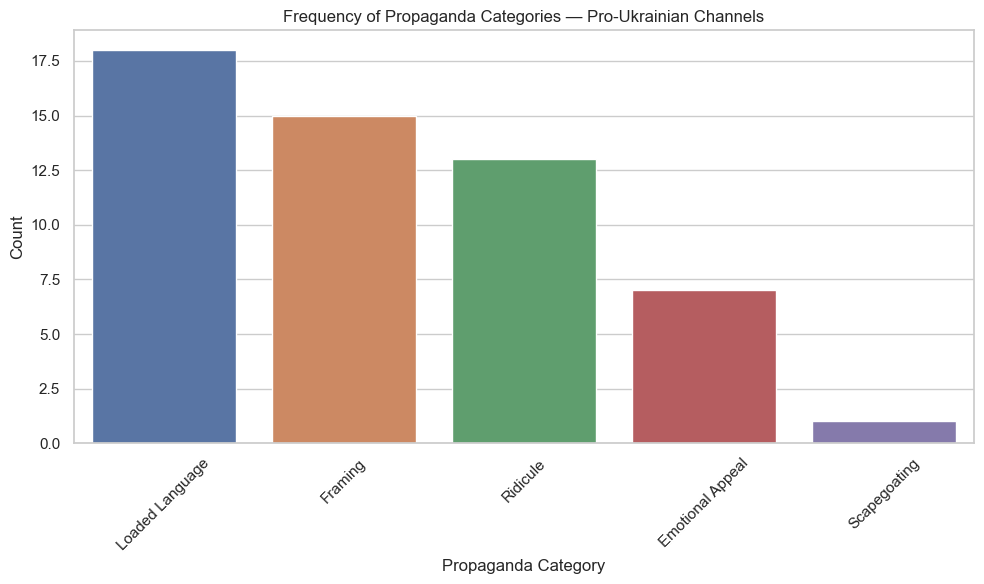

In [50]:
# --- Pro-Ukrainian ---
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_ukr,
    x="propaganda_category",
    order=df_ukr["propaganda_category"].value_counts().index
)
plt.xticks(rotation=45)
plt.title("Frequency of Propaganda Categories — Pro-Ukrainian Channels")
plt.xlabel("Propaganda Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/ukr/propaganda_freq_ukr.png", dpi=600, bbox_inches="tight")
plt.show()

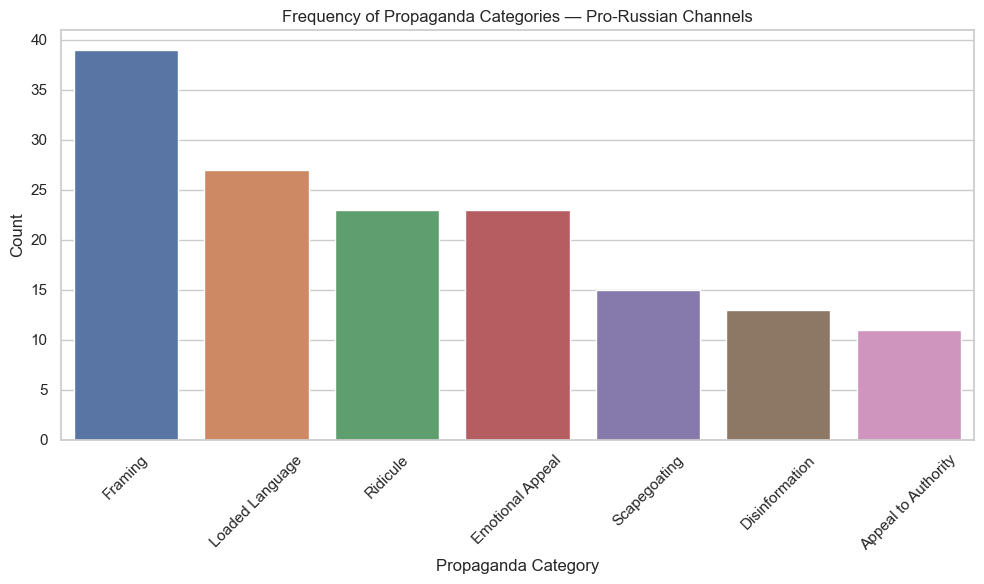

In [51]:
# --- Pro-Russian ---
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_rus,
    x="propaganda_category",
    order=df_rus["propaganda_category"].value_counts().index
)
plt.xticks(rotation=45)
plt.title("Frequency of Propaganda Categories — Pro-Russian Channels")
plt.xlabel("Propaganda Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/ru/propaganda_freq_ru.png", dpi=600, bbox_inches="tight")
plt.show()

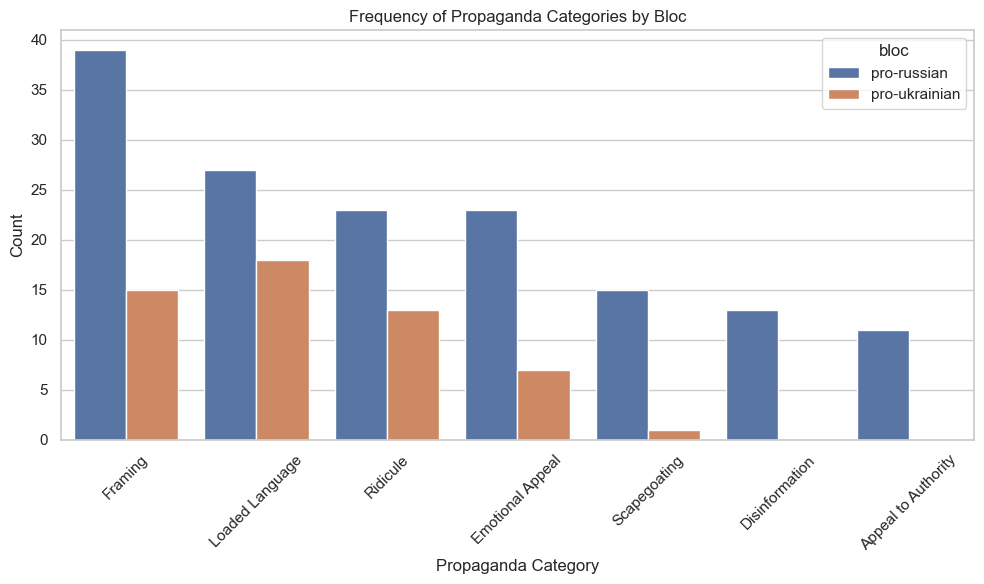

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_exploded, x="propaganda_category", hue="bloc", order=df_exploded["propaganda_category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Frequency of Propaganda Categories by Bloc")
plt.xlabel("Propaganda Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/propaganda_freq.png", dpi=600, bbox_inches="tight")
plt.show()

In [53]:
df_relevant.columns = df_relevant.columns.str.strip().str.replace(r"\\t", "", regex=True)

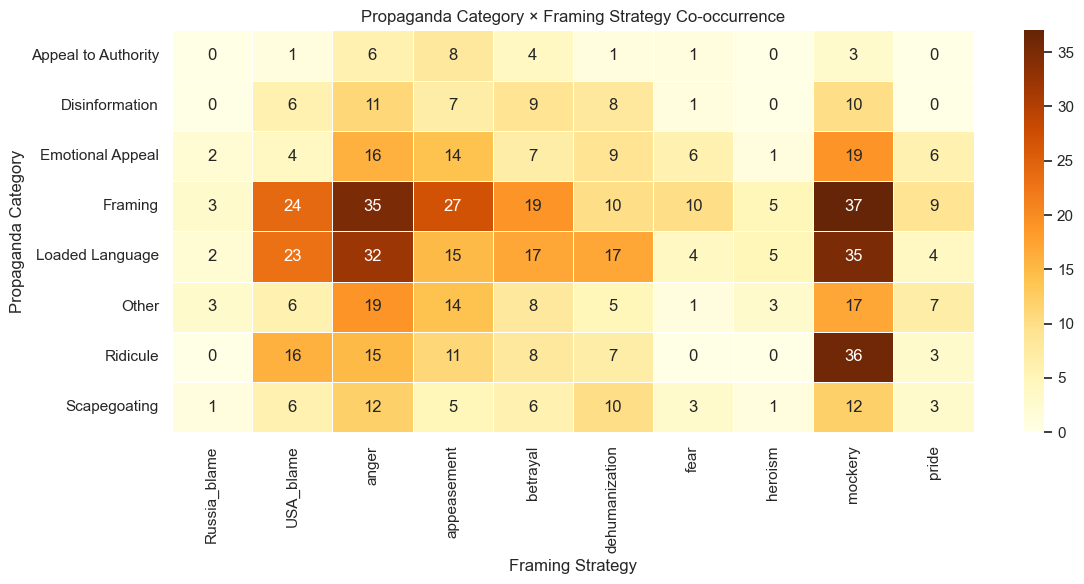

In [54]:
# Exploding propaganda_category to have one row per category
df_exploded = df_relevant.explode("propaganda_category")

# Defining list of framing columns (adjust if needed)
framing_cols = ["betrayal", "heroism", "appeasement", "fear", "anger", "pride",
    "dehumanization", "mockery", "USA_blame", "Russia_blame"]

# Melting framing variables into long format
df_framing_melted = df_exploded.melt(
    id_vars=["propaganda_category"], 
    value_vars=framing_cols,
    var_name="Framing_Strategy", 
    value_name="Presence"
)

# Filtering only those where framing strategy is present
df_framing_present = df_framing_melted[df_framing_melted["Presence"] == 1]

# Creating crosstab
cooccurrence = pd.crosstab(
    df_framing_present["propaganda_category"], 
    df_framing_present["Framing_Strategy"]
)

# Plotting heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="YlOrBr", linewidths=0.5)
plt.title("Propaganda Category × Framing Strategy Co-occurrence")
plt.xlabel("Framing Strategy")
plt.ylabel("Propaganda Category")
plt.tight_layout()
plt.savefig("figures/propaganda_categ_binary_coocur.png", dpi=600, bbox_inches="tight")
plt.show()

In [67]:
# Defining list of framing columns
framing_cols = [
    "betrayal","heroism","appeasement","fear","anger","pride",
    "dehumanization","mockery","USA_blame","Russia_blame"
]

os.makedirs("figures/ukr", exist_ok=True)
os.makedirs("figures/ru", exist_ok=True)

def plot_heatmap_for_bloc(data, bloc_name):
    # 0) Sanity: keep only framing columns that actually exist
    missing = [c for c in framing_cols if c not in data.columns]
    if missing:
        print(f"[{bloc_name}] Missing framing columns: {missing}")
    use_cols = [c for c in framing_cols if c in data.columns]

    df_bloc = data.loc[data["bloc"] == bloc_name].copy()

    # 1) Normalize propaganda_category to list-like and drop empties
    def to_list(x):
        if isinstance(x, list):
            return x
        if pd.isna(x) or x is None:
            return []
        return [x]  # treat singletons as one-item lists

    df_bloc["propaganda_category"] = df_bloc["propaganda_category"].apply(to_list)

    df_exploded = df_bloc.explode("propaganda_category", ignore_index=True)
    df_exploded = df_exploded.dropna(subset=["propaganda_category"])

    if df_exploded.empty:
        print(f"[{bloc_name}] No propaganda_category entries after explode.")
        return

    # 2) Melt framing vars
    if not use_cols:
        print(f"[{bloc_name}] No valid framing columns to analyze.")
        return

    df_framing_melted = df_exploded.melt(
        id_vars=["propaganda_category"],
        value_vars=use_cols,
        var_name="Framing_Strategy",
        value_name="Presence"
    )

    # 3) Keep present frames (treat True as 1 as well)
    df_framing_present = df_framing_melted[df_framing_melted["Presence"].isin([1, True])]

    if df_framing_present.empty:
        print(f"[{bloc_name}] No rows with Presence == 1.")
        return

    # 4) Co-occurrence table
    cooccurrence = pd.crosstab(
        df_framing_present["propaganda_category"],
        df_framing_present["Framing_Strategy"]
    )

    if cooccurrence.size == 0 or cooccurrence.shape[0] == 0 or cooccurrence.shape[1] == 0:
        print(f"[{bloc_name}] Co-occurrence table is empty.")
        return

    # 5) Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="YlOrBr", linewidths=0.5)
    plt.title(f"Propaganda Category × Framing Strategy — {bloc_name} Channels")
    plt.xlabel("Framing Strategy")
    plt.ylabel("Propaganda Category")
    plt.tight_layout()

    if bloc_name == "pro-Ukrainian":
        save_path = "figures/ukr/heatmap_propaganda_framing_ukr.png"
    elif bloc_name == "pro-Russian":
        save_path = "figures/ru/heatmap_propaganda_framing_ru.png"
    else:
        os.makedirs(f"figures/{bloc_name}", exist_ok=True)
        save_path = f"figures/{bloc_name}/heatmap_propaganda_framing.png"

    plt.savefig(save_path, dpi=600, bbox_inches="tight")
    plt.show()
    print(f"[{bloc_name}] Saved: {save_path}")

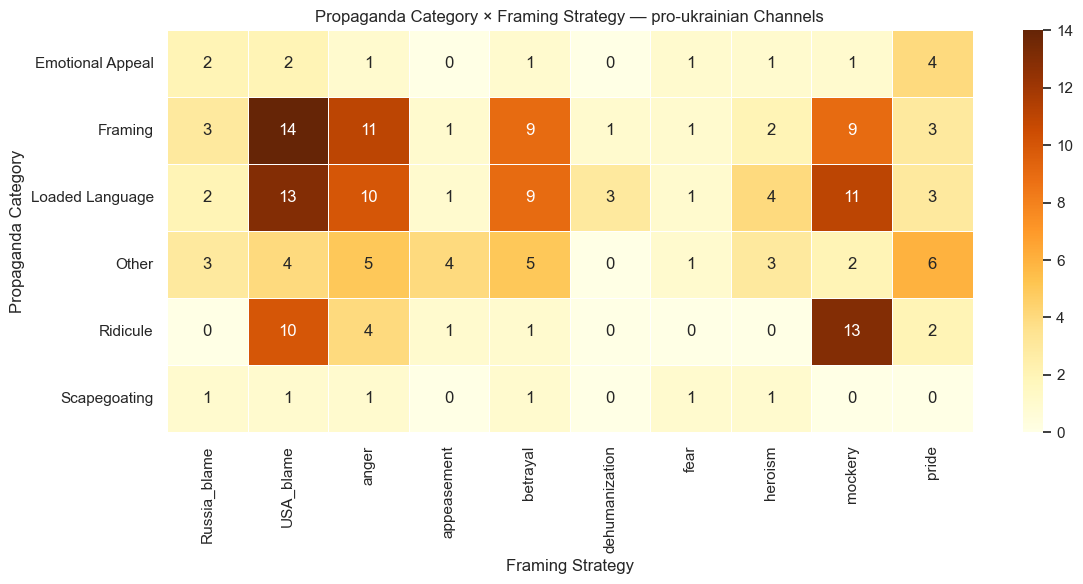

[pro-ukrainian] Saved: figures/pro-ukrainian/heatmap_propaganda_framing.png


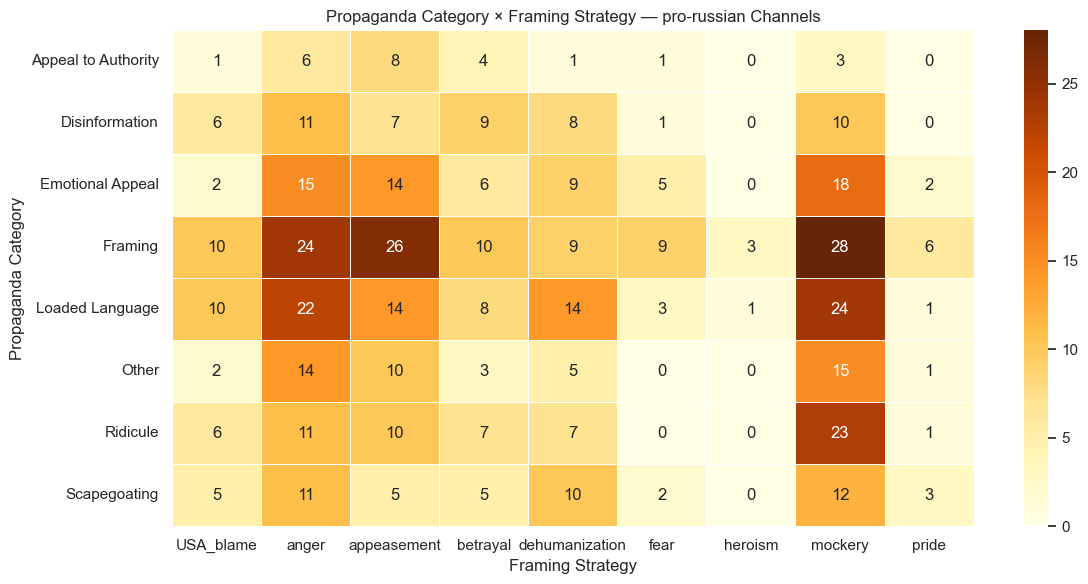

[pro-russian] Saved: figures/pro-russian/heatmap_propaganda_framing.png


In [68]:
# Running for both blocs
plot_heatmap_for_bloc(df_relevant, "pro-ukrainian")
plot_heatmap_for_bloc(df_relevant, "pro-russian")

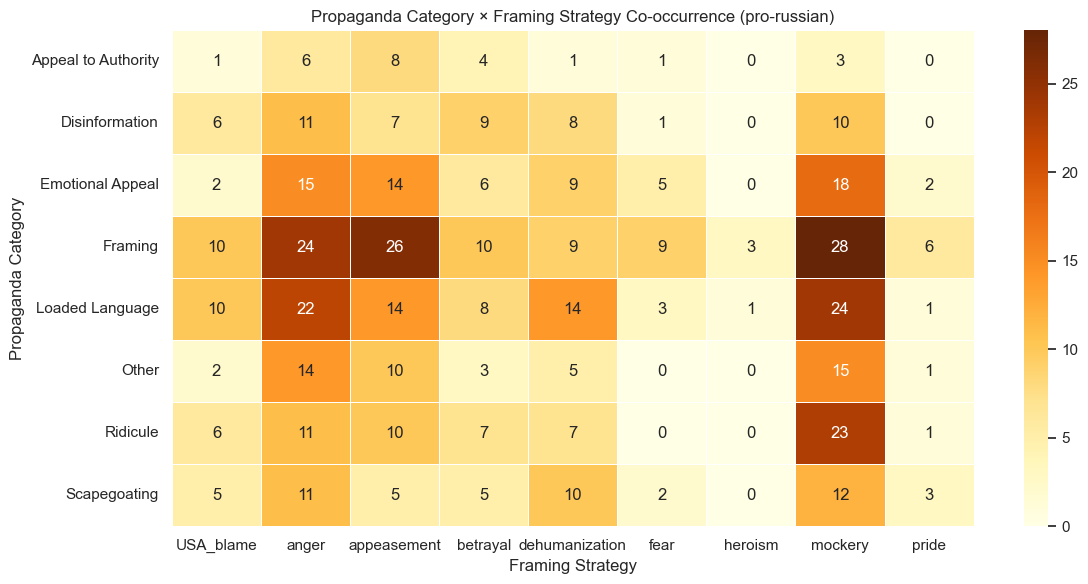

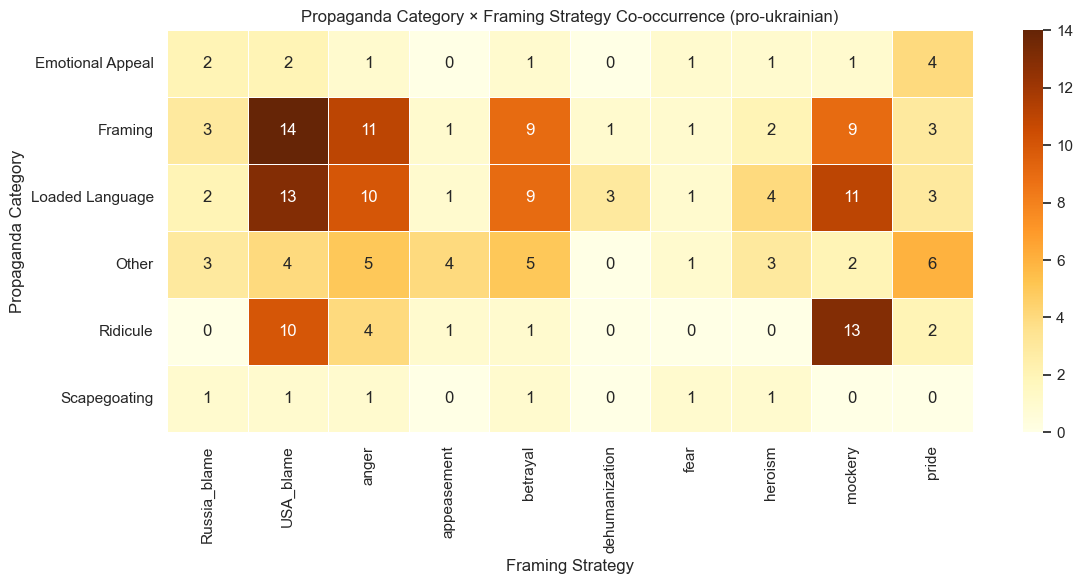

In [69]:
# Defining framing columns (adjust if necessary)
framing_cols = ["betrayal", "heroism", "appeasement", "fear", "anger", "pride",
                "dehumanization", "mockery", "USA_blame", "Russia_blame"]

# Melting framing strategies to long format
df_framing_melted = df_exploded.melt(
    id_vars=["bloc", "propaganda_category"], 
    value_vars=framing_cols,
    var_name="Framing_Strategy", 
    value_name="Presence"
)

# Keeping only present framing strategies
df_framing_present = df_framing_melted[df_framing_melted["Presence"] == 1]

# Separating by bloc
for bloc in df_framing_present["bloc"].unique():
    df_bloc = df_framing_present[df_framing_present["bloc"] == bloc]
    
    cooccurrence = pd.crosstab(
        df_bloc["propaganda_category"], 
        df_bloc["Framing_Strategy"]
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="YlOrBr", linewidths=0.5)
    plt.title(f"Propaganda Category × Framing Strategy Co-occurrence ({bloc})")
    plt.xlabel("Framing Strategy")
    plt.ylabel("Propaganda Category")
    plt.tight_layout()
    plt.show()